Using covariance from a suite of tracers to design the diffusion matrix.

Correlation of tracer fields, whether between a cell and its neighbors and just
between adjacent cells, reveals small and medium scale patterns that follow
intuition. Correlation is typically greater in the along-channel direction
than in the across-channel direction, consistent with the notion that advection
dominates dispersion at these scales.

We tested the applicability of these relationships to tuning the diffusion-based
extrapolation approach.


The diffusion-based approach relies on a prescribed diffusion coefficient which
may be constant, spatially variable but isotropic, or spatially variable and anisotropic.
It additionally requires a decay rate parameter which controls how smoothly the
predicted field transitions between observation points.

For a nominal diffusion coefficient of 100 m$^2$ s$^{-1}$, a decay rate of 
1e-5 s$^{-1}$ gave the best agreement with mapping data when tested against 
turbidity data.

Explored tying the diffusion coefficient to 
Tying the diffusion to correlation did not change accuracy

In [1]:
import stompy.model.delft.dflow_model as dfm
from stompy.grid import unstructured_grid
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import colors
import pandas as pd
import statsmodels.formula.api as smf
from IPython import display

from stompy.spatial import proj_utils
from stompy.spatial import interp_4d
import six

from stompy import utils

%matplotlib notebook

In [2]:
from stompy.model import data_comparison
import extrap_common
six.moves.reload_module(extrap_common)

<module 'extrap_common' from '/home/rustyh/src/sfb_csc_dfm/model/extrap_common.py'>

In [3]:
#model=dfm.DFlowModel.load("data_2d_2019_hybrid-v033")
#model=dfm.DFlowModel.load("data_2d_2018_hybrid-v003")
#model=dfm.DFlowModel.load("data_2d_2018_hybrid-v008")
# includes chl, and all names have been shortened in the inputs and model.
model=dfm.DFlowModel.load("data_2d_2018_hybrid-v009")

In [4]:
fig_dir=os.path.join(model.run_dir,'figures')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    

In [5]:
map_ds=model.map_dataset()

/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:872: RuntimeWarning: invalid value encountered in cast
  ug.edges['cells'] = nc[mesh.attrs['edge_face_connectivity']].values


In [6]:
g=map_ds.grid

In [7]:
cov_tracers=[
    'mesh2d_tauDecay0',
    'mesh2d_tauDecay1',
    'mesh2d_turb_wt',
    'mesh2d_turb_wtobs',
    'mesh2d_sa1',
]

def nice(s):
    return {
    'mesh2d_tauDecay0':r'$\tau_0$',
    'mesh2d_tauDecay1':r'$\tau_1$',
    'mesh2d_turb_wt':r'turb wt',
    'mesh2d_turb_wtobs':r'turb wt*obs',
    'mesh2d_sa1':r'salinity',
    }.get(s,s)

<IPython.core.display.Javascript object>


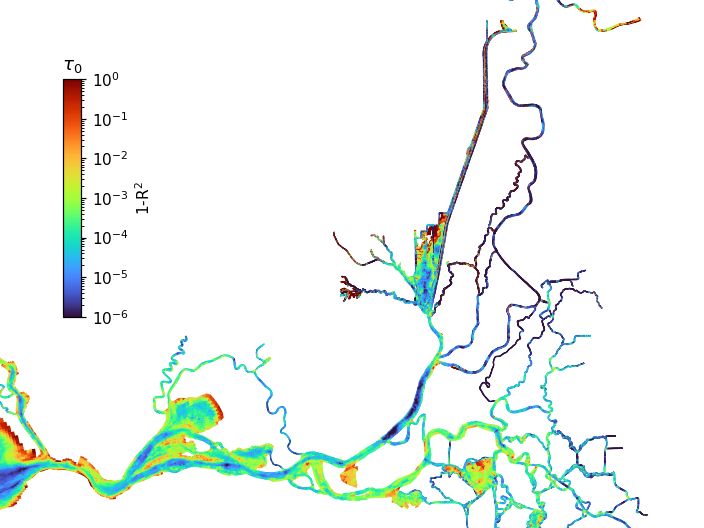

In [9]:
# Extract and visualize covariance for one tracer: R2 for each cell

for tracer in ['mesh2d_tauDecay0']: # cov_tracers:
    regress_fn=os.path.join(fig_dir,f"regress-neighbors-v01-{tracer}.nc")
    ds=xr.open_dataset(regress_fn)

    fig,ax=plt.subplots()
    ax.set_adjustable('datalim')

    # The correlation values are very high almost everywhere.
    # It does slightly highlight junctions where
    ax.set_position([0,0,1,1])
    ax.axis('off')

    div = (1.0 - ds['R2'].values).clip(1e-6,1.0)

    ccoll=map_ds.grid.plot_cells(values=div, norm=colors.LogNorm(), cmap='turbo',
                                 lw=0.7,ec='face',ax=ax)
    cax=fig.add_axes([0.09,0.4,0.025,0.45])
    plt.colorbar(ccoll,label='1-R$^2$', cax=cax)
    ax.axis( (569340., 642705., 4204749., 4273084.))
    cax.set_title(nice(tracer))
    fig.savefig(os.path.join(fig_dir,f'corr-map-{tracer}.png'),dpi=200)


The next question is how to translate the regression coefficients into a matrix.
One option is to use them nearly as is -- each cell gets a row in the matrix
populated by those coefficients and $R^2$.
The exact weighting of those is up for debate.

As $R^2 \rightarrow 1$, the weight of the cell should diminish and the row will contain
the regression coefficients, normalized to sum to 1.0
As $R^2 \rightarrow 0$, the weight of the cell should tend to 1.0. There must be some
handling of particularly low values of R and the possibility of negative 
coefficients.
All coefficients clipped to some nominally small value, say 1e-3.
$R^2$ clipped to $[1e-3,1.0]$

There may be some reason to add a nonlinear map, esp. if the coefficients are
too close to equal.

Another approach would be to take the average coefficient for each edge
and map those to diffusivities.
interp_4d needs a decay rate.
as is, we don't specify edge or cell depth. unstructured_diffuser is just doing the default.
K_j is initialized to 100, but can be updated.
so keep everything else the same, and use the correlation information to reduce K_j
by some factor.

More appropriate to use an edge-centered approach. This keeps the resulting method
symmetric, and is also a smaller departure from the existing code. Unfortunately
the coefficients from regression are not good candidates for an edge-centered 
approach. If a cell has two edges and one neighboring cell is slightly more predictive
then the coefficients could be 1.0 for that edge and 0.0 for the slightly less predictive
neighbor. In many cases that other edge has a negative coefficient.

In [10]:
# What's the distribution of coefficients, and how do the two sides relate?
edge_coeffs=np.zeros((g.Nedges(),2),np.float64)

e2c=g.edge_to_cells()

nbrs=ds.nbr_index.values # [cell, nbr]
coeffs=ds.coeffs.values # [cell, nbr]

for j in range(g.Nedges()):
    c1,c2=e2c[j]
    if c1<0 or c2<0: continue
        
    for he,cA,cB in [ (0,c1,c2), (1,c2,c1)]:
        for i,nbr in enumerate(nbrs[cA]):
            if nbr<0: break
            if nbr==cB: 
                edge_coeffs[j,he]=coeffs[cA,i]
                break

<IPython.core.display.Javascript object>


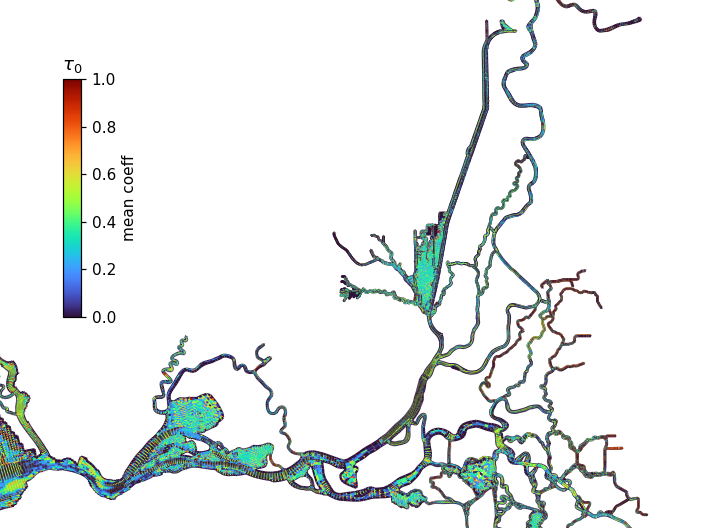

<IPython.core.display.Javascript object>


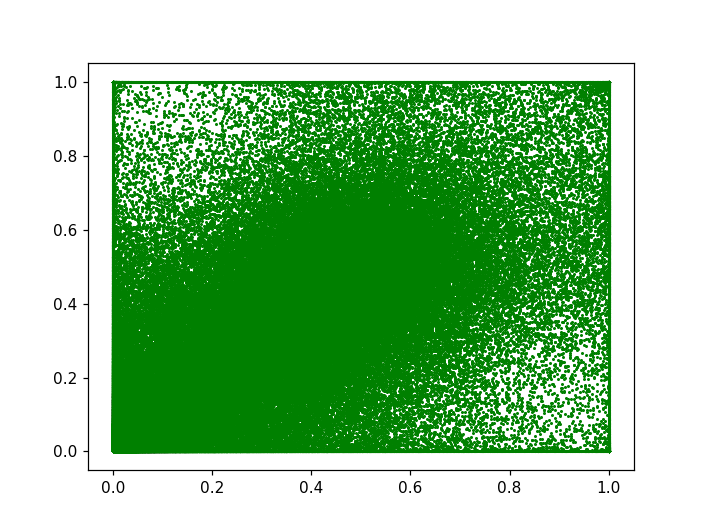

In [11]:
# Spatial view of edge-average coefficients
# In broad channels the longitudinal correlation dominates, leaving near zero
# values laterally. Coefficients are too sensitive.

# And something based on edge-centered correlation would be better.
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
ax.set_position([0,0,1,1])
ax.axis('off')

edge_value=edge_coeffs.clip(0,1).mean(axis=1)

ccoll=map_ds.grid.plot_edges(values=edge_value, 
                             #norm=colors.LogNorm(), 
                             cmap='turbo',
                             lw=1.5,ax=ax)
cax=fig.add_axes([0.09,0.4,0.025,0.45])
plt.colorbar(ccoll,label='mean coeff', cax=cax)
ax.axis( (569340., 642705., 4204749., 4273084.))
cax.set_title(nice(tracer))
fig.savefig(os.path.join(fig_dir,f'coeff-edge_map-{tracer}.png'),dpi=200)

# And how symmetric are the coefficients? Not.
fig,ax=plt.subplots()

ax.plot(edge_coeffs[:,0].clip(0,1), 
        edge_coeffs[:,1].clip(0,1),
        'g.',ms=2)

<IPython.core.display.Javascript object>


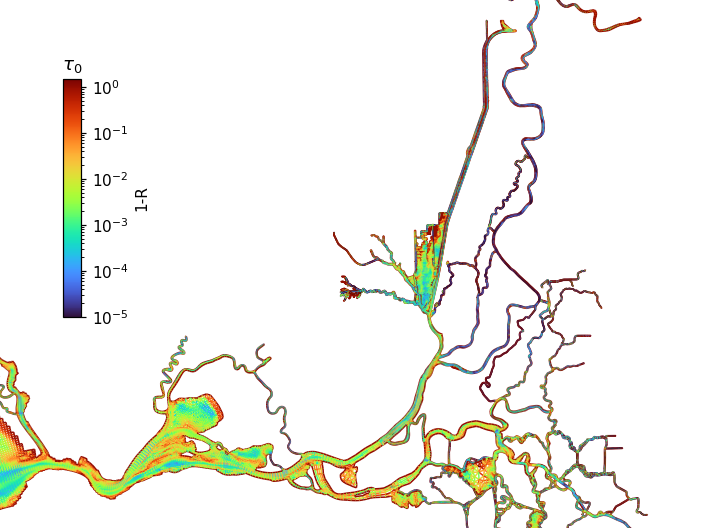

In [12]:
# Extract and visualize correlation on edges for one tracer
for tracer in ['mesh2d_tauDecay0']: # cov_tracers:
    regress_fn=os.path.join(fig_dir,f"regress-edges-v01-{tracer}.nc")
    ds=xr.open_dataset(regress_fn)
    
    fig,ax=plt.subplots()
    ax.set_adjustable('datalim')

    ax.set_position([0,0,1,1])
    ax.axis('off')

    div = (1.0 - ds['R'].values).clip(1e-5)

    ccoll=map_ds.grid.plot_edges(values=div, norm=colors.LogNorm(), cmap='turbo',
                                 lw=1,ax=ax)
    cax=fig.add_axes([0.09,0.4,0.025,0.45])
    plt.colorbar(ccoll,label='1-R', cax=cax)
    ax.axis( (569340., 642705., 4204749., 4273084.))
    cax.set_title(nice(tracer))
    fig.savefig(os.path.join(fig_dir,f'corr-edge_map-{tracer}.png'),dpi=200)

<IPython.core.display.Javascript object>


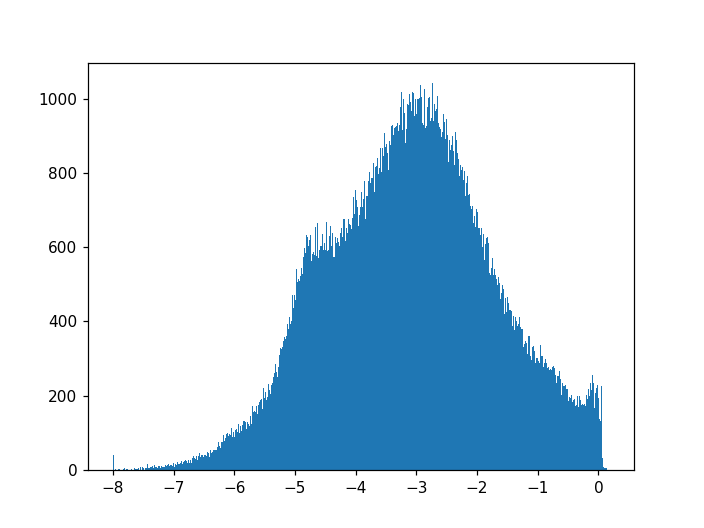

In [13]:
plt.figure()
R=ds['R'].values
valid=R!=0.0 # drop boundary edges.
plt.hist( np.log10( (1-R[valid]).clip(1e-8) ),bins=500)
None

Interpolation
--

Fallback: diffusion. We have continuous data at a number of locations, and
can diffuse that throughout the domain. DONE.

Advection & diffusion: use the advected field with weights as input to 
the same diffusion process.

Predictive model: Some sort of fit of turb ~ tauDecay1 + tauDecay2 + ???
Needs work.
 - would like this to have some spatial variability. I guess we'd get 
   coefficients at each station, and those coefficients could be extrapolated
   with diffusion. Unclear if there are issues with mixing coefficients -- i.e.
   if $a_i$ is a good set of parameters and $b_i$ is a good set, is an affine
   combination of them also good?
 - from the model output and monitoring stations we can fit per-station
   predictive models. The coefficients in these models could be extrapolated
   in space. For something like sediment this could be problematic. Might come up
   with a great model for turb ~ tau in the channel, and then the relationship in
   a nearby shallow is very different. Suggests that we really want a hierarchical
   model, where some coefficient are site-specific, but other coefficients are
   global, such as the role of local depth.
   
Hybrid model: predictive model where there is no data, advection/diffusion
  model where there is data.
  
Analysis
--

With each of those synthesize hourly snapshots at the time of cruises, from
which linear interpolated points can be extracted to match up with cruise
data. Test relative skill across the methods.

In [11]:
# Load cruises, plot, then develop some machinery to predict at 
# cruise locations.

six.moves.reload_module(extrap_common)
cruise_df = extrap_common.load_cruises()
cruise_df_thin = cruise_df.iloc[::30].copy() # 11.8k turb points, 11.8k cond
cruise_df_thin.describe()

/home/rustyh/mambaforge/envs/general310/lib/python3.10/site-packages/osgeo/osr.py:385: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


,time,x,y,turb,cond,chl
count,11837,11837.000000,1.183700e+04,11793.000000,11837.000000,11706.000000
mean,2018-08-10 19:48:40.175720192,620023.870900,4.223666e+06,9.608728,1370.145200,2.062041
min,2018-05-15 15:40:00,575516.936107,4.187874e+06,0.150000,44.700000,0.000000
25%,2018-07-24 16:08:00,614954.089345,4.212076e+06,3.400000,155.800000,0.682906
50%,2018-07-26 22:38:00,618533.380535,4.222504e+06,5.400000,201.900000,1.400000
75%,2018-10-17 17:19:00,629622.545761,4.234582e+06,9.200000,376.500000,2.500000
max,2018-10-20 00:26:00,646990.362367,4.270206e+06,148.700000,31114.700000,67.000000
std,NaN,13589.222075,1.617691e+04,14.318352,4012.951282,2.657180


In [27]:
six.moves.reload_module(extrap_common)

<module 'extrap_common' from '/home/rustyh/src/sfb_csc_dfm/model/extrap_common.py'>

In [28]:
from stompy import memoize

class CorrelationPredictor(extrap_common.PreparedPredictor):
    mon_field='turb'
    # Together these define the mapping from log-deviation to diffusion
    # coefficient. Not yet clear which is more appropriate to tune.
    
    # With this it got a very minor bump in R2 over straight diffusion.
    K_power = 1.0 # increase to have a steeper rolloff in K
    logDev0 = 1.0 # decrease to have a steeper rolloff in K.
    
    # R2 was not sensitive to K_power, at least not with logDev0=1.0
    # 0.837 to 0.833 for K_power 1 to 3.0, with decreasing skill 
    # at larger powers.
    
    # R2 was not sensitive to logDev0, with R2 ranging from 
    # 0.837 to 0.821 for logDev0 1.0 to 0.025.
    
    K_factor="call set_K_factor first"
    
    regress_fn=None # os.path.join(fig_dir,f"regress-edges-v01-{tracer}.nc")
    def __init__(self,*a,**kw):
        super().__init__(*a,**kw)
        self.set_K_factor()
    def set_K_factor(self):
        ds=xr.open_dataset(regress_fn)
        # Will probably explore some transformations here
        # 1-R is distributed roughly log-ish over [1e-5, 1.0]
        minDev = 1e-5
        # so dev[iation] is roughly [1,1e5]
        dev = (1.0-ds['R']).clip(minDev) / minDev
        # [0,5]
        logDev = np.log10(dev) # brackets most of the data
                
        # What if we amplify that effect?
        self.K_factor = (1/(1+logDev/self.logDev0))**self.K_power
        
    @memoize.imemoize()
    def predict_map(self,t):
        snap = self.mon_ds.sel(time=t,method='nearest')
        valid = np.isfinite(snap[self.mon_field].values)
        # Triggering a strange xarray/netcdf issue.
        for trojan in ['station_nm','site_no']:
            if trojan in snap:
                snap=snap.drop(trojan)
        snap_v = snap.isel(site=valid)

        df=snap_v.to_dataframe() #[ 'x','y','turbidity']
        df=df[ ['x','y',self.mon_field] ]
        df['weight']=1.0

        predicted=self.get_prepared().process(samples=df, value_col=self.mon_field)

        return predicted

Compare maps of snapshots
==

In [12]:
# Compare map snapshots between diffusion and adv-diffusion
six.moves.reload_module(extrap_common)
if 1:
    analyte='turb'
    clim=[1,100]
    c_log=True
    units='FNU'

if 0:
    analyte='cond'
    clim=[100,10000]
    c_log=True
    units='uS/cm'

if 0:
    analyte='chl'
    clim=[1,50]
    c_log=True
    units='ug/l'
    
mon_ds=extrap_common.mon_dataset(analyte)

In [18]:
tracer='mesh2d_tauDecay0'
regress_fn=os.path.join(fig_dir,f"regress-edges-v01-{tracer}.nc")
 
cor_predictor=CorrelationPredictor(regress_fn=regress_fn,
                                   grid=map_ds.grid,
                                   mon_ds=mon_ds,
                                   mon_field=analyte)

In [19]:
diff_predictor=extrap_common.DiffusionPredictor(grid=map_ds.grid, mon_ds=mon_ds, mon_field=analyte)

In [20]:
ad_predictor=extrap_common.AdvDiffPredictor(map_ds=map_ds,scal=analyte,alpha=5e-4,min_weight=0.0)

<IPython.core.display.Javascript object>


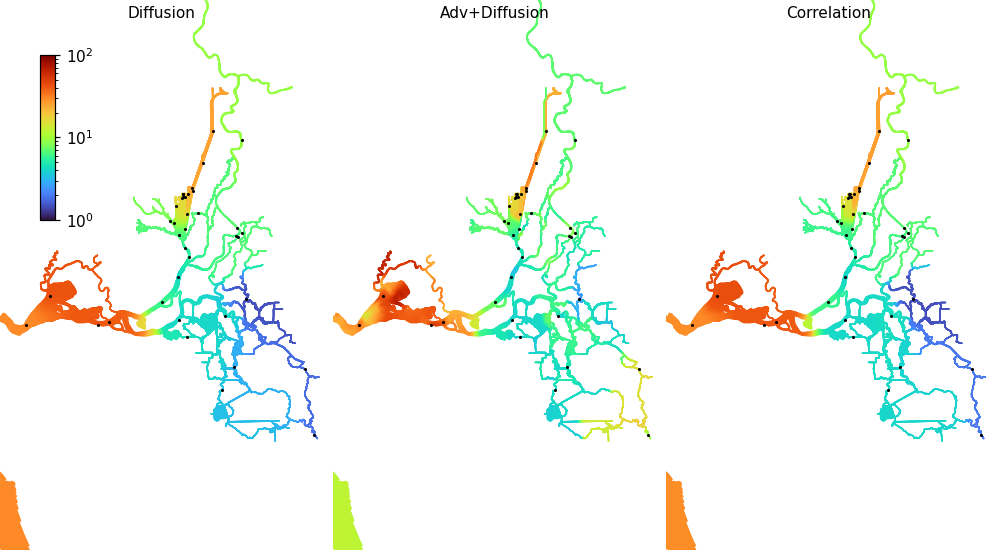

Checking finite geometry
Checking finite geometry
Checking finite geometry


In [21]:

g=map_ds.grid

zoom=(570210., 651279., 4177852., 4269280.)
fig,axs=plt.subplots(1,3,figsize=(9.0,5.0))
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.03)
cax=fig.add_axes([0.04,0.6,0.016,0.3])


if 0:
    frame_dir=os.path.join(fig_dir,f'frames-{analyte}')
    if not os.path.exists(frame_dir):
        os.makedirs(frame_dir)
    tidxs=range(1300,1500)
else:
    frame_dir=None
    tidxs=[1400]

for frame,tidx in enumerate(tidxs):
    if frame_dir is not None:
        img_fn=os.path.join(frame_dir,f'frame-{frame:04d}.png')
        if os.path.exists(img_fn):
            continue
        
    for ax,pred,label in zip(axs,
                             [diff_predictor,ad_predictor,cor_predictor],
                             ['Diffusion','Adv+Diffusion','Correlation']):
        ax.cla()
        ax.axis('off')
        ax.set_adjustable('datalim')

        scal=pred.predict_map(map_ds.time.values[tidx])

        missing=np.isnan(scal)
        ccoll=g.plot_cells(values=scal,cmap='turbo',ax=ax,lw=0.8,edgecolor='face',mask=~missing)
        g.plot_cells(mask=missing,color="0.8",ax=ax,lw=0.5,edgecolor='face')
        ccoll.set_clim(clim)
        ccoll.set_norm(colors.LogNorm(vmin=clim[0],vmax=clim[1]))

        # Show station locations
        ax.plot( mon_ds.x, mon_ds.y, 'k.', ms=2)
        ax.text(0.5,0.99,label,transform=ax.transAxes,ha='center',va='top')
        #for i,site in enumerate(mon_ds.site.values):
        #    ax.text(mon_ds.x[i], mon_ds.y[i], site, clip_on=True)

        ax.axis(zoom)

    cax.cla()
    plt.colorbar(ccoll,cax=cax)

    if frame_dir is not None:
        fig.savefig(img_fn)

In [22]:
pnt_franks_tract = [622900, 4211500]

In [10]:
if 0:
    from stompy.plot import mkanim

    anim_fn=os.path.join(frame_dir,'movie.mp4')

    mkanim.mkanim(out=anim_fn,
                  frame_path=os.path.join(frame_dir,'frame-%04d.png'),
                  fps=10)
    display.Video(anim_fn)

While the adv-diffusion based reconstruction has a lower $r$ than the diffusion result, it degrades more gracefully far from observations. Diffusion alone has no "memory" and large portions of the domain can
have predictions that fluctuate over a short time scales.

In [12]:
tracer='mesh2d_tauDecay0'
regress_fn=os.path.join(fig_dir,f"regress-edges-v01-{tracer}.nc") 
cor_predictor=CorrelationPredictor(regress_fn=regress_fn,
                                   grid=map_ds.grid,
                                   mon_ds=mon_ds,
                                   mon_field=analyte)
cor_result=cor_predictor.predict_underway(cruise_df_thin)

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry


INFO:utils:1


Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00
Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:

INFO:utils:21


Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00
Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:00 -- 2018-05-17T20:00:00
Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:

INFO:utils:42


Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:00 -- 2018-07-25T15:00:00
Processing 2018-07-25T15:00:00 -- 2018-07-25T16:00:00
Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:

INFO:utils:61


Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00
Processing 2018-08-23T16:00:00 -- 2018-08-23T17:00:00
Processing 2018-08-23T17:00:00 -- 2018-08-23T18:00:00
Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:

INFO:utils:80


Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:00 -- 2018-09-13T22:00:00
Processing 2018-09-13T22:00:00 -- 2018-09-13T23:00:00
Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:

INFO:utils:99


Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:00 -- 2018-10-18T18:00:00
Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:

INFO:utils:118


Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


In [15]:
diff_predictor=extrap_common.DiffusionPredictor(grid=map_ds.grid, mon_ds=mon_ds,mon_field=analyte)
diff_result=diff_predictor.predict_underway(cruise_df_thin)

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry
Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00


INFO:utils:6


Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:00 -- 2018-05-17T01:00:00
Processing 2018-05-17T15:00:00 -- 2018-05-17T16:00:00
Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00
Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:

INFO:utils:25


Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:00 -- 2018-07-25T01:00:00
Processing 2018-07-25T01:00:00 -- 2018-07-25T02:00:00
Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:

INFO:utils:45


Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00
Processing 2018-08-23T16:00:

INFO:utils:64


Processing 2018-08-23T17:00:00 -- 2018-08-23T18:00:00
Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:

INFO:utils:83


Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:00 -- 2018-09-13T22:00:00
Processing 2018-09-13T22:00:00 -- 2018-09-13T23:00:00
Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:

INFO:utils:102


Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:00 -- 2018-10-18T18:00:00
Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:

INFO:utils:121


Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


In [ ]:
ad_predictor=extrap_common.AdvDiffPredictor(map_ds=map_ds,scal=analyte,alpha=1e-5,min_weight=0.5)
ad_result=ad_predictor.predict_underway(cruise_df_thin)

<IPython.core.display.Javascript object>


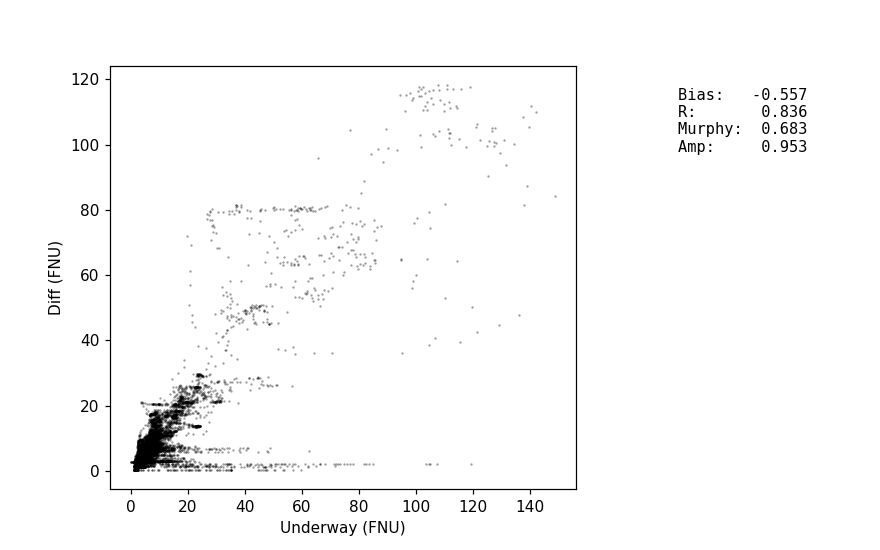

<IPython.core.display.Javascript object>


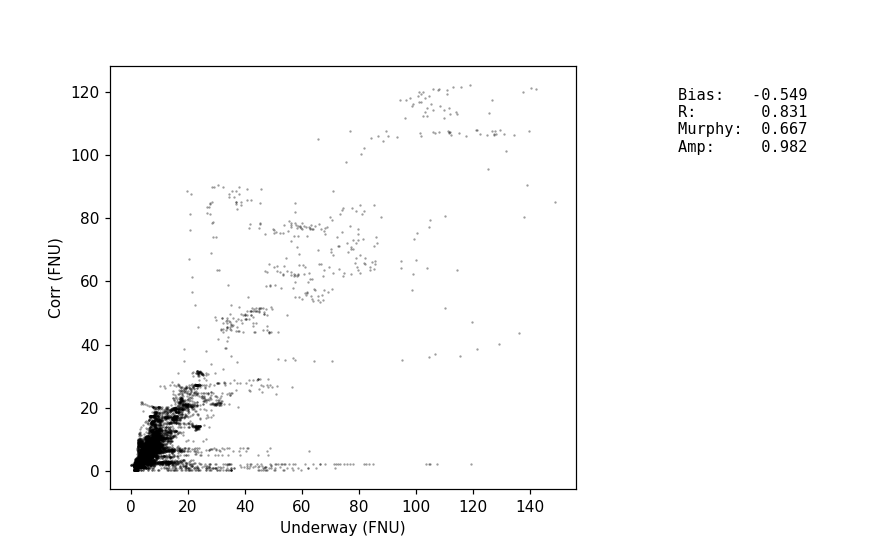

In [17]:
# TURB
#   For reference, straight diffusion from the observations is R=0.836, Amp=1.05 for tu

# R=0.831, Amp=0.978 for min_weight=0.9
# R=0.836, Amp=0.923 for min_weight=0.8
# R=0.837, Amp=0.824 for min_weight=0.5
# R=0.814, Amp=0.716 for 

# COND

# R: 0.989 for diffusion, 0.984 for AD
#  very similar murphy. Amplitudes were on either side of 1.0, 
#  fairly comparable.

# CHL

# R: 0.324 for diffusion, 0.329 for AD
#  murphy -0.89 vs. -0.014
# so neither are that great.

#valid = np.isfinite(ad_result + diff_result)
#extrap_evaluate(ad_result[valid],   cruise_df_thin['turb'].values[valid], label='Adv-diff (FNU)')
fig1=extrap_common.extrap_evaluate(diff_result, cruise_df_thin[analyte], label=f'Diff ({units})')
fig2=extrap_common.extrap_evaluate(cor_result, cruise_df_thin[analyte], label=f'Corr ({units})')
#fig3=extrap_evaluate(ad_result, cruise_df_thin[analyte], label=f'AD ({units})')



Extrapolation based on the past measurements advected forward does not improve the predictive
skill. Isolated features, such as a pulse of turbid waters injected into Franks Tract, demonstrate
the concept, but on the whole skill is worse for turbidity. 

For conductivity the gradients are smaller, with less local variability. Both methods
attain high correlation, almost identical.

For chlorophyll the drivers are less obviously spatial, and neither method is very good.
AD is marginally better.

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry
Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00


INFO:utils:6


Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:00 -- 2018-05-17T01:00:00
Processing 2018-05-17T15:00:00 -- 2018-05-17T16:00:00
Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00
Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:

INFO:utils:25


Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:00 -- 2018-07-25T01:00:00
Processing 2018-07-25T01:00:00 -- 2018-07-25T02:00:00
Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:

INFO:utils:45


Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00
Processing 2018-08-23T16:00:

INFO:utils:64


Processing 2018-08-23T17:00:00 -- 2018-08-23T18:00:00
Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:

INFO:utils:83


Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:00 -- 2018-09-13T22:00:00
Processing 2018-09-13T22:00:00 -- 2018-09-13T23:00:00
Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:

INFO:utils:102


Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:00 -- 2018-10-18T18:00:00
Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:

INFO:utils:121


Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


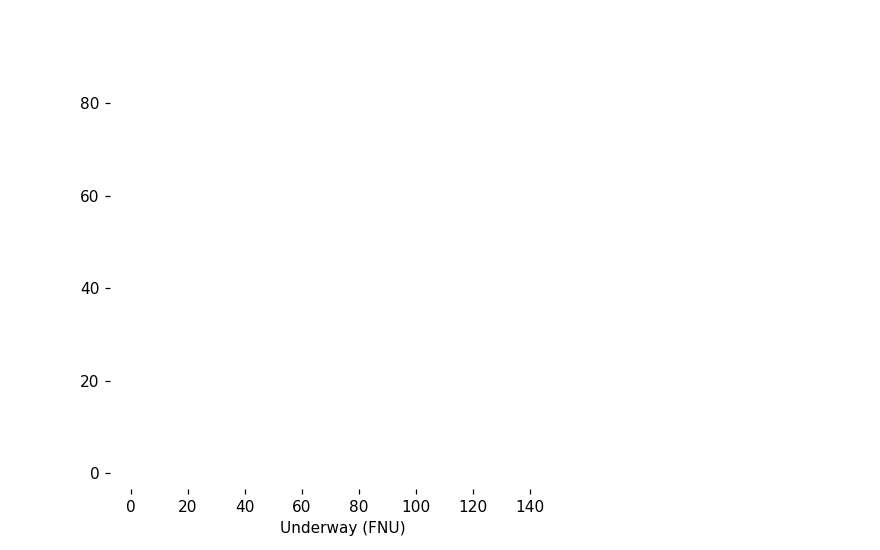

Diff $lpha$=1e-06 (FNU)

    Bias:   -0.780
    R:       0.809
    Murphy:  0.645
    Amp:     0.730

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry
Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00


INFO:utils:6


Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:00 -- 2018-05-17T01:00:00
Processing 2018-05-17T15:00:00 -- 2018-05-17T16:00:00
Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00
Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:

INFO:utils:25


Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:00 -- 2018-07-25T01:00:00
Processing 2018-07-25T01:00:00 -- 2018-07-25T02:00:00
Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:

INFO:utils:45


Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00
Processing 2018-08-23T16:00:

INFO:utils:64


Processing 2018-08-23T17:00:00 -- 2018-08-23T18:00:00
Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:

INFO:utils:83


Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:00 -- 2018-09-13T22:00:00
Processing 2018-09-13T22:00:00 -- 2018-09-13T23:00:00
Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:

INFO:utils:103


Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:00 -- 2018-10-18T18:00:00
Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:

<IPython.core.display.Javascript object>


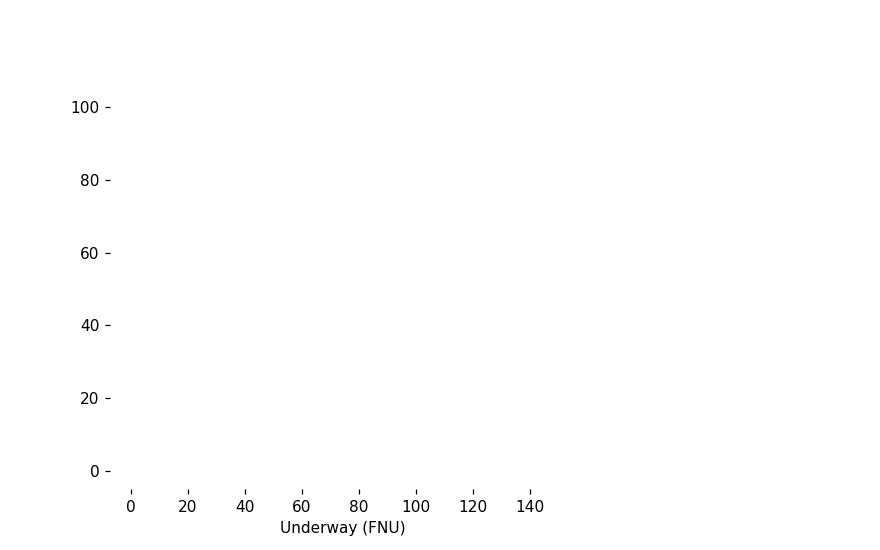

Diff $lpha$=3e-06 (FNU)

    Bias:   -0.587
    R:       0.832
    Murphy:  0.689
    Amp:     0.859

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry
Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00


INFO:utils:6


Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:00 -- 2018-05-17T01:00:00
Processing 2018-05-17T15:00:00 -- 2018-05-17T16:00:00
Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00
Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:

INFO:utils:26


Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:00 -- 2018-07-25T01:00:00
Processing 2018-07-25T01:00:00 -- 2018-07-25T02:00:00
Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:00 -- 2018-07-25T15:00:00
Processing 2018-07-25T15:00:

INFO:utils:46


Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00
Processing 2018-08-23T16:00:00 -- 2018-08-23T17:00:00
Processing 2018-08-23T17:00:

INFO:utils:66


Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:

INFO:utils:86


Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:

INFO:utils:105


Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


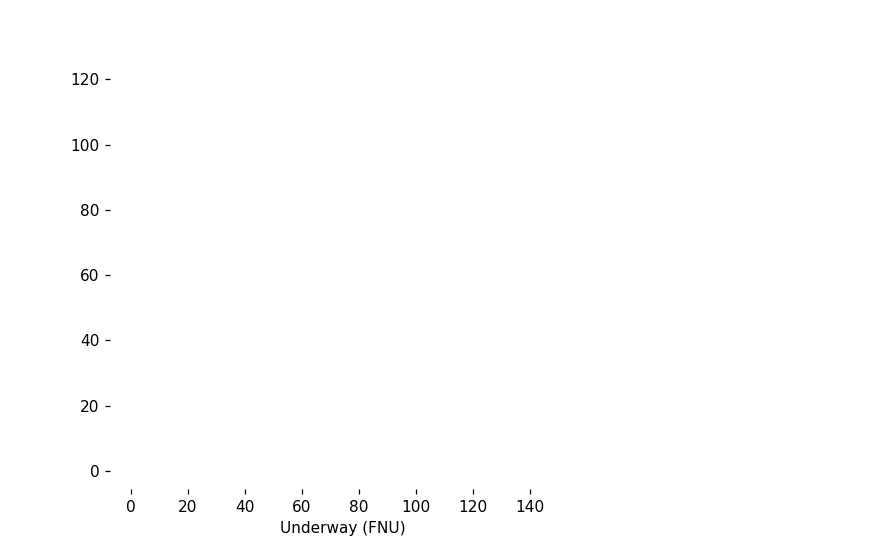

Diff $lpha$=1e-05 (FNU)

    Bias:   -0.557
    R:       0.836
    Murphy:  0.683
    Amp:     0.953

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry
Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00


INFO:utils:6


Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:00 -- 2018-05-17T01:00:00
Processing 2018-05-17T15:00:00 -- 2018-05-17T16:00:00
Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00
Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:

INFO:utils:26


Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:00 -- 2018-07-25T01:00:00
Processing 2018-07-25T01:00:00 -- 2018-07-25T02:00:00
Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:00 -- 2018-07-25T15:00:00
Processing 2018-07-25T15:00:

INFO:utils:46


Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00
Processing 2018-08-23T16:00:00 -- 2018-08-23T17:00:00
Processing 2018-08-23T17:00:

INFO:utils:66


Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:

INFO:utils:85


Processing 2018-09-13T22:00:00 -- 2018-09-13T23:00:00
Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:

INFO:utils:104


Processing 2018-10-18T17:00:00 -- 2018-10-18T18:00:00
Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


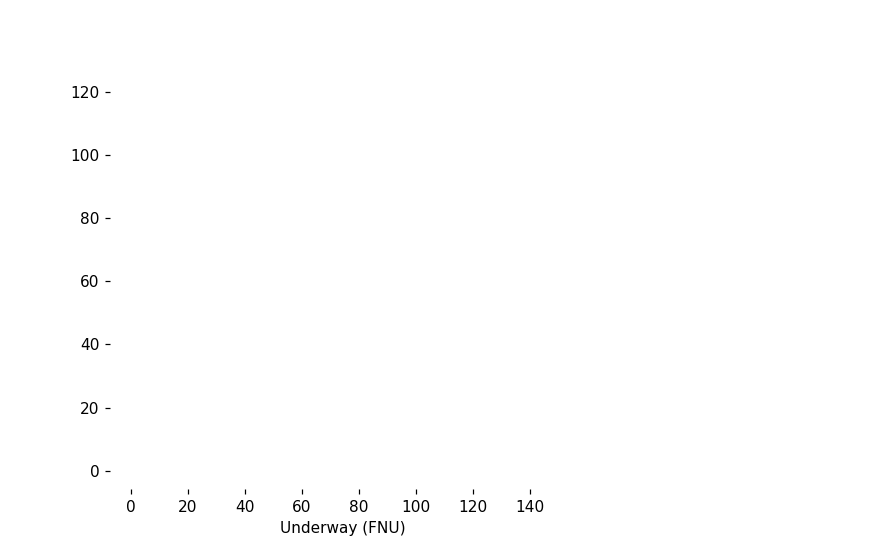

Diff $lpha$=3e-05 (FNU)

    Bias:   -0.538
    R:       0.829
    Murphy:  0.657
    Amp:     0.996

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry
Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00


INFO:utils:6


Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:00 -- 2018-05-17T01:00:00
Processing 2018-05-17T15:00:00 -- 2018-05-17T16:00:00
Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00
Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:

INFO:utils:26


Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:00 -- 2018-07-25T01:00:00
Processing 2018-07-25T01:00:00 -- 2018-07-25T02:00:00
Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:00 -- 2018-07-25T15:00:00
Processing 2018-07-25T15:00:

INFO:utils:46


Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00
Processing 2018-08-23T16:00:00 -- 2018-08-23T17:00:00
Processing 2018-08-23T17:00:

INFO:utils:66


Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:

INFO:utils:86


Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:

INFO:utils:105


Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


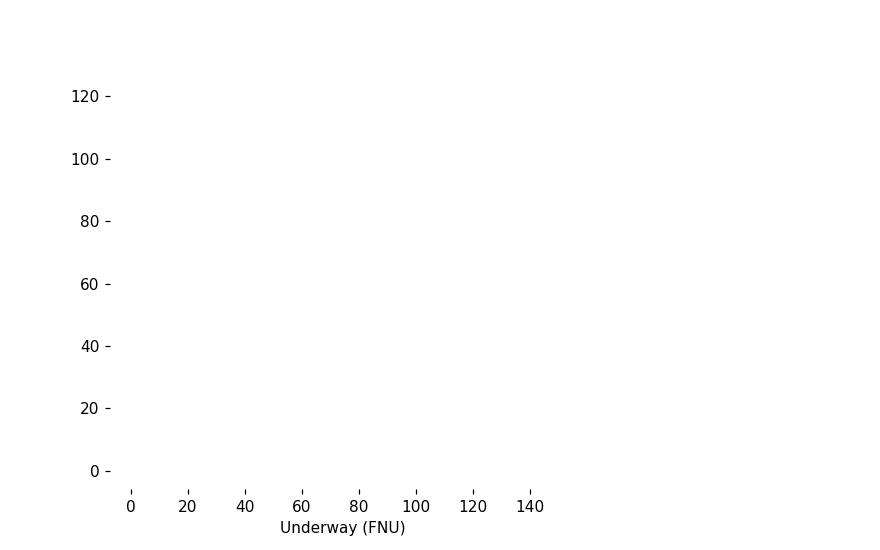

Diff $lpha$=0.0001 (FNU)

    Bias:   -0.460
    R:       0.816
    Murphy:  0.619
    Amp:     1.031



In [14]:
six.moves.reload_module(extrap_common)

# Scanning alpha values for diffusion solver
# alpha=1e-5 was the best.
for alpha in [1e-6,3e-6,1e-5,3e-5,1e-4]:
    diff_predictor=extrap_common.DiffusionPredictor(grid=map_ds.grid, mon_ds=mon_ds,mon_field=analyte,
                                                    alpha=alpha)
    diff_result=diff_predictor.predict_underway(cruise_df_thin)
    fig=extrap_common.extrap_evaluate(diff_result, cruise_df_thin[analyte], 
                                      label=f'Diff $\\alpha$={alpha} ({units})')

In [22]:
cor_predictor.prepared.alpha

1e-06

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry


INFO:utils:1


Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00
Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:

INFO:utils:22


Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:00 -- 2018-05-17T20:00:00
Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:

INFO:utils:44


Processing 2018-07-25T15:00:00 -- 2018-07-25T16:00:00
Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:

INFO:utils:65


Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:

INFO:utils:86


Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:

INFO:utils:105


Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


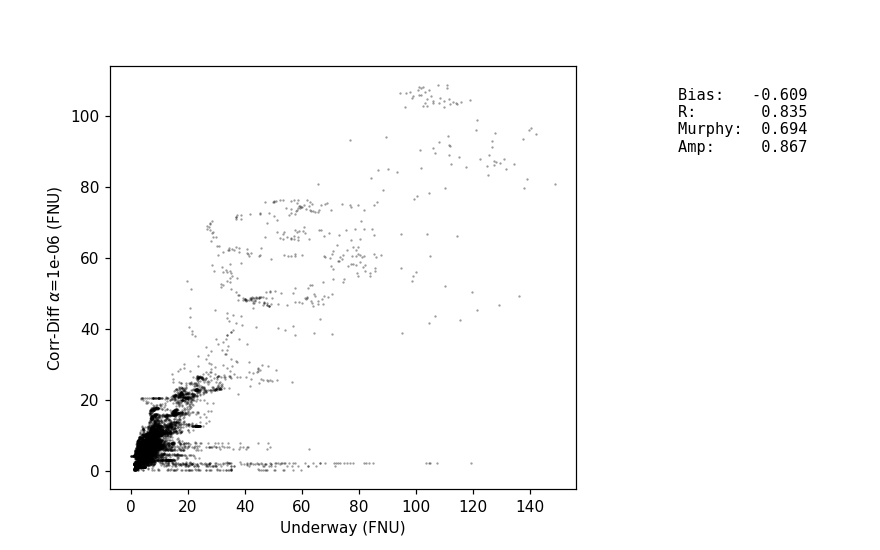

Corr-Diff $\alpha$=1e-06 (FNU)

    Bias:   -0.609
    R:       0.835
    Murphy:  0.694
    Amp:     0.867

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry


INFO:utils:1


Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00
Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:

INFO:utils:22


Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:00 -- 2018-05-17T20:00:00
Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:

INFO:utils:44


Processing 2018-07-25T15:00:00 -- 2018-07-25T16:00:00
Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:

INFO:utils:65


Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:

INFO:utils:86


Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:

INFO:utils:106


Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


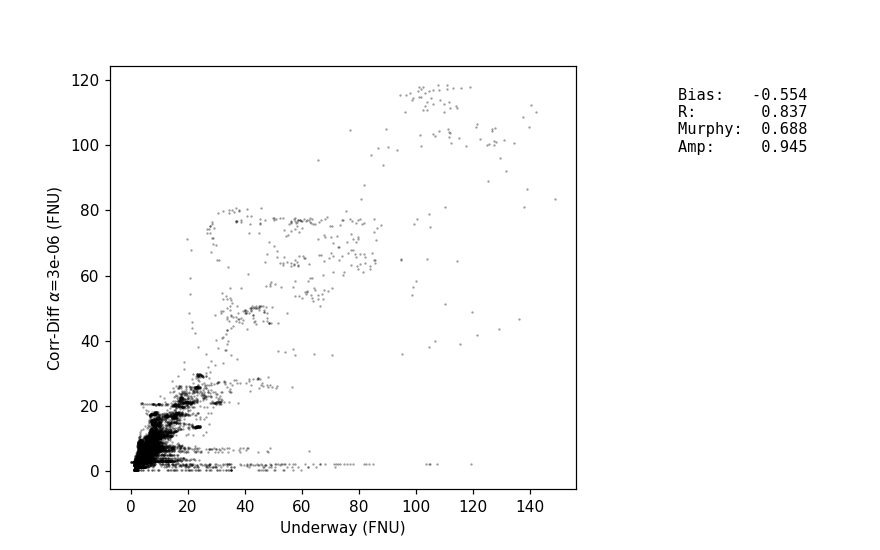

Corr-Diff $\alpha$=3e-06 (FNU)

    Bias:   -0.554
    R:       0.837
    Murphy:  0.688
    Amp:     0.945

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry


INFO:utils:1


Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00
Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:

INFO:utils:22


Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:00 -- 2018-05-17T20:00:00
Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:

INFO:utils:44


Processing 2018-07-25T15:00:00 -- 2018-07-25T16:00:00
Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:

INFO:utils:65


Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:

INFO:utils:86


Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:

INFO:utils:106


Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


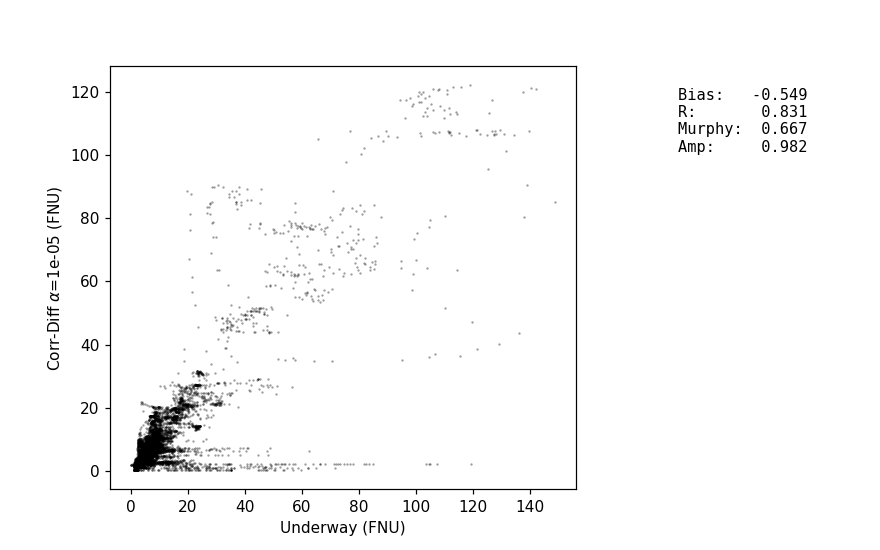

Corr-Diff $\alpha$=1e-05 (FNU)

    Bias:   -0.549
    R:       0.831
    Murphy:  0.667
    Amp:     0.982

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry


INFO:utils:1


Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00
Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:

INFO:utils:22


Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:00 -- 2018-05-17T20:00:00
Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:

INFO:utils:44


Processing 2018-07-25T15:00:00 -- 2018-07-25T16:00:00
Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:

INFO:utils:65


Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:

INFO:utils:86


Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:

INFO:utils:105


Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


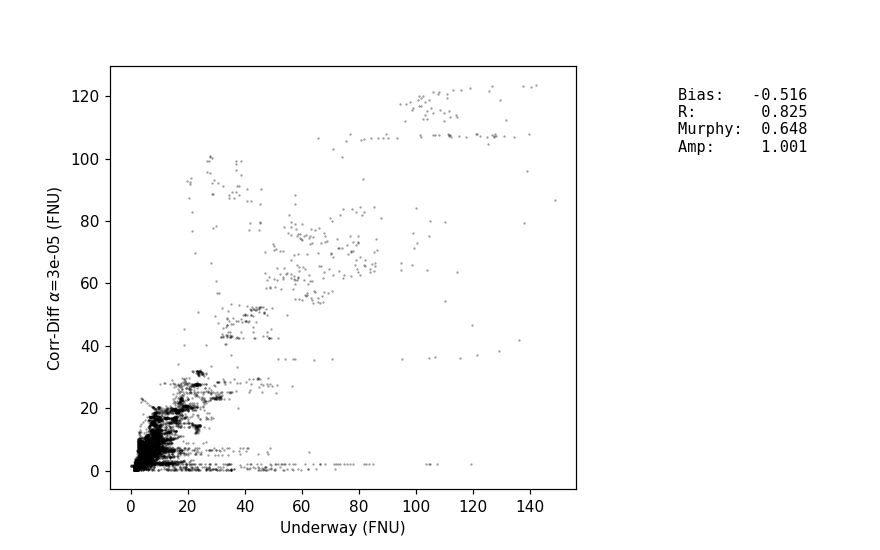

Corr-Diff $\alpha$=3e-05 (FNU)

    Bias:   -0.516
    R:       0.825
    Murphy:  0.648
    Amp:     1.001

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry


INFO:utils:1


Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00
Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:

INFO:utils:22


Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:00 -- 2018-05-17T20:00:00
Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:

INFO:utils:44


Processing 2018-07-25T15:00:00 -- 2018-07-25T16:00:00
Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:

INFO:utils:65


Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:

INFO:utils:86


Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:

INFO:utils:106


Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00
Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


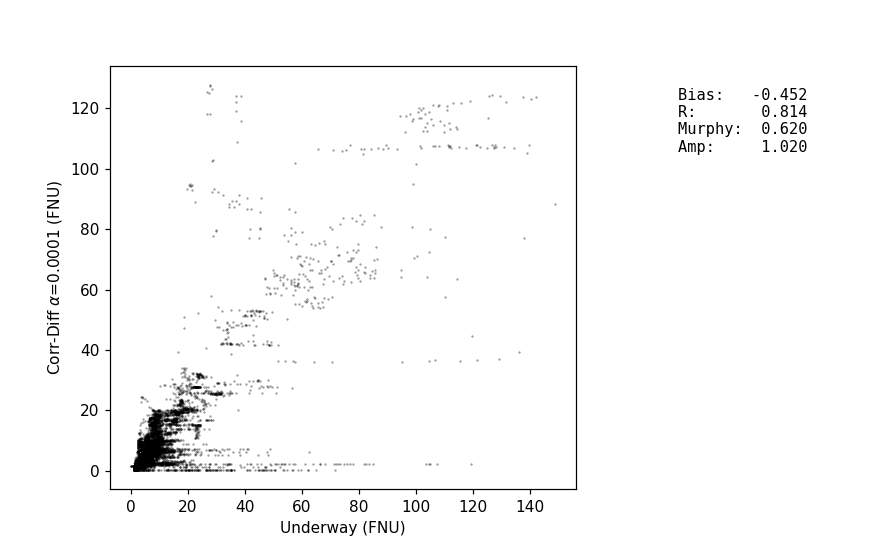

Corr-Diff $\alpha$=0.0001 (FNU)

    Bias:   -0.452
    R:       0.814
    Murphy:  0.620
    Amp:     1.020



In [23]:
tracer='mesh2d_tauDecay0'
regress_fn=os.path.join(fig_dir,f"regress-edges-v01-{tracer}.nc") 

# Scanning alpha values for correlation solver
# 3e-6 was the best, with R2=0.837.

for alpha in [1e-6,3e-6,1e-5,3e-5,1e-4]:
    cor_predictor=CorrelationPredictor(regress_fn=regress_fn,
                                       grid=map_ds.grid,
                                       alpha=alpha,
                                       mon_ds=mon_ds,
                                       mon_field=analyte)
    cor_result=cor_predictor.predict_underway(cruise_df_thin)
    fig=extrap_common.extrap_evaluate(cor_result, cruise_df_thin[analyte], 
                                      label=f'Corr-Diff $\\alpha$={alpha} ({units})')

In [29]:
tracer='mesh2d_tauDecay0'
regress_fn=os.path.join(fig_dir,f"regress-edges-v01-{tracer}.nc") 

# Scanning K_power values for correlation solver
# 3e-6 was the best, with R2=0.837.

for alpha in [1e-6,3e-6,1e-5]:
    for K_power in [0.5, 1.0, 1.5]:
        for logDev0 in [5,2,1,0.5]:
            cor_predictor=CorrelationPredictor(regress_fn=regress_fn,
                                               grid=map_ds.grid,
                                               alpha=alpha,
                                               K_power=K_power,
                                               logDev0=logDev0,
                                               mon_ds=mon_ds,
                                               mon_field=analyte)
            cor_result=cor_predictor.predict_underway(cruise_df_thin)
            label=f'Corr-Diff ({units})\nKpow={K_power:g} $\\alpha$={alpha} logDev0={logDev0:g}'
            fig=extrap_common.extrap_evaluate(cor_result, cruise_df_thin[analyte], 
                                              label=label, plot=False)

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=1e-06 logDev0=5

    Bias:   -0.738
    R:       0.815
    Murphy:  0.658
    Amp:     0.756

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=1e-06 logDev0=2

    Bias:   -0.704
    R:       0.820
    Murphy:  0.669
    Amp:     0.781

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=1e-06 logDev0=1

    Bias:   -0.672
    R:       0.825
    Murphy:  0.678
    Amp:     0.806

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=1e-06 logDev0=0.5

    Bias:   -0.638
    R:       0.830
    Murphy:  0.687
    Amp:     0.834

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1 $\alpha$=1e-06 logDev0=5

    Bias:   -0.704
    R:       0.820
    Murphy:  0.669
    Amp:     0.781

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1 $\alpha$=1e-06 logDev0=2

    Bias:   -0.650
    R:       0.829
    Murphy:  0.685
    Amp:     0.825

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1 $\alpha$=1e-06 logDev0=1

    Bias:   -0.609
    R:       0.835
    Murphy:  0.694
    Amp:     0.867

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1 $\alpha$=1e-06 logDev0=0.5

    Bias:   -0.575
    R:       0.838
    Murphy:  0.696
    Amp:     0.909

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=1e-06 logDev0=5

    Bias:   -0.675
    R:       0.825
    Murphy:  0.678
    Amp:     0.804

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=1e-06 logDev0=2

    Bias:   -0.613
    R:       0.835
    Murphy:  0.694
    Amp:     0.863

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=1e-06 logDev0=1

    Bias:   -0.576
    R:       0.839
    Murphy:  0.696
    Amp:     0.912

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=1e-06 logDev0=0.5

    Bias:   -0.559
    R:       0.838
    Murphy:  0.688
    Amp:     0.948

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=3e-06 logDev0=5

    Bias:   -0.576
    R:       0.834
    Murphy:  0.693
    Amp:     0.877

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=3e-06 logDev0=2

    Bias:   -0.568
    R:       0.836
    Murphy:  0.694
    Amp:     0.894

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=3e-06 logDev0=1

    Bias:   -0.562
    R:       0.837
    Murphy:  0.694
    Amp:     0.910

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=3e-06 logDev0=0.5

    Bias:   -0.557
    R:       0.837
    Murphy:  0.691
    Amp:     0.928

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1 $\alpha$=3e-06 logDev0=5

    Bias:   -0.568
    R:       0.836
    Murphy:  0.694
    Amp:     0.894

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1 $\alpha$=3e-06 logDev0=2

    Bias:   -0.559
    R:       0.838
    Murphy:  0.693
    Amp:     0.922

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1 $\alpha$=3e-06 logDev0=1

    Bias:   -0.554
    R:       0.837
    Murphy:  0.688
    Amp:     0.945

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1 $\alpha$=3e-06 logDev0=0.5

    Bias:   -0.550
    R:       0.835
    Murphy:  0.680
    Amp:     0.963

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=3e-06 logDev0=5

    Bias:   -0.563
    R:       0.837
    Murphy:  0.694
    Amp:     0.908

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=3e-06 logDev0=2

    Bias:   -0.556
    R:       0.838
    Murphy:  0.690
    Amp:     0.941

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=3e-06 logDev0=1

    Bias:   -0.555
    R:       0.836
    Murphy:  0.681
    Amp:     0.961

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=3e-06 logDev0=0.5

    Bias:   -0.552
    R:       0.833
    Murphy:  0.674
    Amp:     0.971

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=1e-05 logDev0=5

    Bias:   -0.557
    R:       0.835
    Murphy:  0.680
    Amp:     0.961

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=1e-05 logDev0=2

    Bias:   -0.556
    R:       0.835
    Murphy:  0.677
    Amp:     0.968

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=1e-05 logDev0=1

    Bias:   -0.553
    R:       0.834
    Murphy:  0.674
    Amp:     0.974

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=0.5 $\alpha$=1e-05 logDev0=0.5

    Bias:   -0.548
    R:       0.832
    Murphy:  0.669
    Amp:     0.981

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1 $\alpha$=1e-05 logDev0=5

    Bias:   -0.557
    R:       0.835
    Murphy:  0.678
    Amp:     0.967

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1 $\alpha$=1e-05 logDev0=2

    Bias:   -0.555
    R:       0.833
    Murphy:  0.672
    Amp:     0.976

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:87
INFO:utils:107


Corr-Diff (FNU)
Kpow=1 $\alpha$=1e-05 logDev0=1

    Bias:   -0.549
    R:       0.831
    Murphy:  0.667
    Amp:     0.982

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:87
INFO:utils:108


Corr-Diff (FNU)
Kpow=1 $\alpha$=1e-05 logDev0=0.5

    Bias:   -0.535
    R:       0.829
    Murphy:  0.661
    Amp:     0.988

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=1e-05 logDev0=5

    Bias:   -0.558
    R:       0.834
    Murphy:  0.676
    Amp:     0.971

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=1e-05 logDev0=2

    Bias:   -0.556
    R:       0.832
    Murphy:  0.670
    Amp:     0.979

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=1e-05 logDev0=1

    Bias:   -0.547
    R:       0.831
    Murphy:  0.666
    Amp:     0.981

Checking finite geometry


INFO:utils:1
INFO:utils:22
INFO:utils:44
INFO:utils:65
INFO:utils:86
INFO:utils:106


Corr-Diff (FNU)
Kpow=1.5 $\alpha$=1e-05 logDev0=0.5

    Bias:   -0.530
    R:       0.829
    Murphy:  0.662
    Amp:     0.981



In [ ]:
# Best so far: 0.839 Kpow=1.5, alpha 1e-6, logDev0=1
# But nothing is substantially moving the needle

In [87]:
# Show time series from the two methods at a point in Franks Tract, hopefully demonstrating
# how advection brings in a memory component.
diff_predictor=DiffusionPredictor(grid=map_ds.grid, mon_ds=mon_ds,mon_field=analyte)
ad_predictor=AdvDiffPredictor(map_ds=map_ds,scal=analyte,alpha=1e-5,min_weight=0.5)

franks_df=pd.DataFrame()
franks_df['time'] = map_ds.time.values[1200:1400]
franks_df['x']=pnt_franks_tract[0]
franks_df['y']=pnt_franks_tract[1]

ad_result=ad_predictor.predict_underway(franks_df)
diff_result=diff_predictor.predict_underway(franks_df)

Processing 2018-05-21T00:00:00 -- 2018-05-21T01:00:00
Checking finite geometry
Processing 2018-05-21T01:00:00 -- 2018-05-21T02:00:00
Processing 2018-05-21T02:00:00 -- 2018-05-21T03:00:00
Processing 2018-05-21T03:00:00 -- 2018-05-21T04:00:00
Processing 2018-05-21T04:00:00 -- 2018-05-21T05:00:00


INFO:utils:5


Processing 2018-05-21T05:00:00 -- 2018-05-21T06:00:00
Processing 2018-05-21T06:00:00 -- 2018-05-21T07:00:00
Processing 2018-05-21T07:00:00 -- 2018-05-21T08:00:00
Processing 2018-05-21T08:00:00 -- 2018-05-21T09:00:00
Processing 2018-05-21T09:00:00 -- 2018-05-21T10:00:00
Processing 2018-05-21T10:00:00 -- 2018-05-21T11:00:00
Processing 2018-05-21T11:00:00 -- 2018-05-21T12:00:00
Processing 2018-05-21T12:00:00 -- 2018-05-21T13:00:00
Processing 2018-05-21T13:00:00 -- 2018-05-21T14:00:00
Processing 2018-05-21T14:00:00 -- 2018-05-21T15:00:00
Processing 2018-05-21T15:00:00 -- 2018-05-21T16:00:00
Processing 2018-05-21T16:00:00 -- 2018-05-21T17:00:00
Processing 2018-05-21T17:00:00 -- 2018-05-21T18:00:00
Processing 2018-05-21T18:00:00 -- 2018-05-21T19:00:00
Processing 2018-05-21T19:00:00 -- 2018-05-21T20:00:00
Processing 2018-05-21T20:00:00 -- 2018-05-21T21:00:00
Processing 2018-05-21T21:00:00 -- 2018-05-21T22:00:00
Processing 2018-05-21T22:00:00 -- 2018-05-21T23:00:00
Processing 2018-05-21T23:00:

INFO:utils:25


Processing 2018-05-22T01:00:00 -- 2018-05-22T02:00:00
Processing 2018-05-22T02:00:00 -- 2018-05-22T03:00:00
Processing 2018-05-22T03:00:00 -- 2018-05-22T04:00:00
Processing 2018-05-22T04:00:00 -- 2018-05-22T05:00:00
Processing 2018-05-22T05:00:00 -- 2018-05-22T06:00:00
Processing 2018-05-22T06:00:00 -- 2018-05-22T07:00:00
Processing 2018-05-22T07:00:00 -- 2018-05-22T08:00:00
Processing 2018-05-22T08:00:00 -- 2018-05-22T09:00:00
Processing 2018-05-22T09:00:00 -- 2018-05-22T10:00:00
Processing 2018-05-22T10:00:00 -- 2018-05-22T11:00:00
Processing 2018-05-22T11:00:00 -- 2018-05-22T12:00:00
Processing 2018-05-22T12:00:00 -- 2018-05-22T13:00:00
Processing 2018-05-22T13:00:00 -- 2018-05-22T14:00:00
Processing 2018-05-22T14:00:00 -- 2018-05-22T15:00:00
Processing 2018-05-22T15:00:00 -- 2018-05-22T16:00:00
Processing 2018-05-22T16:00:00 -- 2018-05-22T17:00:00
Processing 2018-05-22T17:00:00 -- 2018-05-22T18:00:00
Processing 2018-05-22T18:00:00 -- 2018-05-22T19:00:00
Processing 2018-05-22T19:00:

INFO:utils:45


Processing 2018-05-22T21:00:00 -- 2018-05-22T22:00:00
Processing 2018-05-22T22:00:00 -- 2018-05-22T23:00:00
Processing 2018-05-22T23:00:00 -- 2018-05-23T00:00:00
Processing 2018-05-23T00:00:00 -- 2018-05-23T01:00:00
Processing 2018-05-23T01:00:00 -- 2018-05-23T02:00:00
Processing 2018-05-23T02:00:00 -- 2018-05-23T03:00:00
Processing 2018-05-23T03:00:00 -- 2018-05-23T04:00:00
Processing 2018-05-23T04:00:00 -- 2018-05-23T05:00:00
Processing 2018-05-23T05:00:00 -- 2018-05-23T06:00:00
Processing 2018-05-23T06:00:00 -- 2018-05-23T07:00:00
Processing 2018-05-23T07:00:00 -- 2018-05-23T08:00:00
Processing 2018-05-23T08:00:00 -- 2018-05-23T09:00:00
Processing 2018-05-23T09:00:00 -- 2018-05-23T10:00:00
Processing 2018-05-23T10:00:00 -- 2018-05-23T11:00:00
Processing 2018-05-23T11:00:00 -- 2018-05-23T12:00:00
Processing 2018-05-23T12:00:00 -- 2018-05-23T13:00:00
Processing 2018-05-23T13:00:00 -- 2018-05-23T14:00:00
Processing 2018-05-23T14:00:00 -- 2018-05-23T15:00:00
Processing 2018-05-23T15:00:

INFO:utils:66


Processing 2018-05-23T18:00:00 -- 2018-05-23T19:00:00
Processing 2018-05-23T19:00:00 -- 2018-05-23T20:00:00
Processing 2018-05-23T20:00:00 -- 2018-05-23T21:00:00
Processing 2018-05-23T21:00:00 -- 2018-05-23T22:00:00
Processing 2018-05-23T22:00:00 -- 2018-05-23T23:00:00
Processing 2018-05-23T23:00:00 -- 2018-05-24T00:00:00
Processing 2018-05-24T00:00:00 -- 2018-05-24T01:00:00
Processing 2018-05-24T01:00:00 -- 2018-05-24T02:00:00
Processing 2018-05-24T02:00:00 -- 2018-05-24T03:00:00
Processing 2018-05-24T03:00:00 -- 2018-05-24T04:00:00
Processing 2018-05-24T04:00:00 -- 2018-05-24T05:00:00
Processing 2018-05-24T05:00:00 -- 2018-05-24T06:00:00
Processing 2018-05-24T06:00:00 -- 2018-05-24T07:00:00
Processing 2018-05-24T07:00:00 -- 2018-05-24T08:00:00
Processing 2018-05-24T08:00:00 -- 2018-05-24T09:00:00
Processing 2018-05-24T09:00:00 -- 2018-05-24T10:00:00
Processing 2018-05-24T10:00:00 -- 2018-05-24T11:00:00
Processing 2018-05-24T11:00:00 -- 2018-05-24T12:00:00
Processing 2018-05-24T12:00:

INFO:utils:87


Processing 2018-05-24T15:00:00 -- 2018-05-24T16:00:00
Processing 2018-05-24T16:00:00 -- 2018-05-24T17:00:00
Processing 2018-05-24T17:00:00 -- 2018-05-24T18:00:00
Processing 2018-05-24T18:00:00 -- 2018-05-24T19:00:00
Processing 2018-05-24T19:00:00 -- 2018-05-24T20:00:00
Processing 2018-05-24T20:00:00 -- 2018-05-24T21:00:00
Processing 2018-05-24T21:00:00 -- 2018-05-24T22:00:00
Processing 2018-05-24T22:00:00 -- 2018-05-24T23:00:00
Processing 2018-05-24T23:00:00 -- 2018-05-25T00:00:00
Processing 2018-05-25T00:00:00 -- 2018-05-25T01:00:00
Processing 2018-05-25T01:00:00 -- 2018-05-25T02:00:00
Processing 2018-05-25T02:00:00 -- 2018-05-25T03:00:00
Processing 2018-05-25T03:00:00 -- 2018-05-25T04:00:00
Processing 2018-05-25T04:00:00 -- 2018-05-25T05:00:00
Processing 2018-05-25T05:00:00 -- 2018-05-25T06:00:00
Processing 2018-05-25T06:00:00 -- 2018-05-25T07:00:00
Processing 2018-05-25T07:00:00 -- 2018-05-25T08:00:00
Processing 2018-05-25T08:00:00 -- 2018-05-25T09:00:00
Processing 2018-05-25T09:00:

INFO:utils:108


Processing 2018-05-25T12:00:00 -- 2018-05-25T13:00:00
Processing 2018-05-25T13:00:00 -- 2018-05-25T14:00:00
Processing 2018-05-25T14:00:00 -- 2018-05-25T15:00:00
Processing 2018-05-25T15:00:00 -- 2018-05-25T16:00:00
Processing 2018-05-25T16:00:00 -- 2018-05-25T17:00:00
Processing 2018-05-25T17:00:00 -- 2018-05-25T18:00:00
Processing 2018-05-25T18:00:00 -- 2018-05-25T19:00:00
Processing 2018-05-25T19:00:00 -- 2018-05-25T20:00:00
Processing 2018-05-25T20:00:00 -- 2018-05-25T21:00:00
Processing 2018-05-25T21:00:00 -- 2018-05-25T22:00:00
Processing 2018-05-25T22:00:00 -- 2018-05-25T23:00:00
Processing 2018-05-25T23:00:00 -- 2018-05-26T00:00:00
Processing 2018-05-26T00:00:00 -- 2018-05-26T01:00:00
Processing 2018-05-26T01:00:00 -- 2018-05-26T02:00:00
Processing 2018-05-26T02:00:00 -- 2018-05-26T03:00:00
Processing 2018-05-26T03:00:00 -- 2018-05-26T04:00:00
Processing 2018-05-26T04:00:00 -- 2018-05-26T05:00:00
Processing 2018-05-26T05:00:00 -- 2018-05-26T06:00:00
Processing 2018-05-26T06:00:

INFO:utils:129


Processing 2018-05-26T09:00:00 -- 2018-05-26T10:00:00
Processing 2018-05-26T10:00:00 -- 2018-05-26T11:00:00
Processing 2018-05-26T11:00:00 -- 2018-05-26T12:00:00
Processing 2018-05-26T12:00:00 -- 2018-05-26T13:00:00
Processing 2018-05-26T13:00:00 -- 2018-05-26T14:00:00
Processing 2018-05-26T14:00:00 -- 2018-05-26T15:00:00
Processing 2018-05-26T15:00:00 -- 2018-05-26T16:00:00
Processing 2018-05-26T16:00:00 -- 2018-05-26T17:00:00
Processing 2018-05-26T17:00:00 -- 2018-05-26T18:00:00
Processing 2018-05-26T18:00:00 -- 2018-05-26T19:00:00
Processing 2018-05-26T19:00:00 -- 2018-05-26T20:00:00
Processing 2018-05-26T20:00:00 -- 2018-05-26T21:00:00
Processing 2018-05-26T21:00:00 -- 2018-05-26T22:00:00
Processing 2018-05-26T22:00:00 -- 2018-05-26T23:00:00
Processing 2018-05-26T23:00:00 -- 2018-05-27T00:00:00
Processing 2018-05-27T00:00:00 -- 2018-05-27T01:00:00
Processing 2018-05-27T01:00:00 -- 2018-05-27T02:00:00
Processing 2018-05-27T02:00:00 -- 2018-05-27T03:00:00
Processing 2018-05-27T03:00:

INFO:utils:149


Processing 2018-05-27T05:00:00 -- 2018-05-27T06:00:00
Processing 2018-05-27T06:00:00 -- 2018-05-27T07:00:00
Processing 2018-05-27T07:00:00 -- 2018-05-27T08:00:00
Processing 2018-05-27T08:00:00 -- 2018-05-27T09:00:00
Processing 2018-05-27T09:00:00 -- 2018-05-27T10:00:00
Processing 2018-05-27T10:00:00 -- 2018-05-27T11:00:00
Processing 2018-05-27T11:00:00 -- 2018-05-27T12:00:00
Processing 2018-05-27T12:00:00 -- 2018-05-27T13:00:00
Processing 2018-05-27T13:00:00 -- 2018-05-27T14:00:00
Processing 2018-05-27T14:00:00 -- 2018-05-27T15:00:00
Processing 2018-05-27T15:00:00 -- 2018-05-27T16:00:00
Processing 2018-05-27T16:00:00 -- 2018-05-27T17:00:00
Processing 2018-05-27T17:00:00 -- 2018-05-27T18:00:00
Processing 2018-05-27T18:00:00 -- 2018-05-27T19:00:00
Processing 2018-05-27T19:00:00 -- 2018-05-27T20:00:00
Processing 2018-05-27T20:00:00 -- 2018-05-27T21:00:00
Processing 2018-05-27T21:00:00 -- 2018-05-27T22:00:00
Processing 2018-05-27T22:00:00 -- 2018-05-27T23:00:00
Processing 2018-05-27T23:00:

INFO:utils:170


Processing 2018-05-28T02:00:00 -- 2018-05-28T03:00:00
Processing 2018-05-28T03:00:00 -- 2018-05-28T04:00:00
Processing 2018-05-28T04:00:00 -- 2018-05-28T05:00:00
Processing 2018-05-28T05:00:00 -- 2018-05-28T06:00:00
Processing 2018-05-28T06:00:00 -- 2018-05-28T07:00:00
Processing 2018-05-28T07:00:00 -- 2018-05-28T08:00:00
Processing 2018-05-28T08:00:00 -- 2018-05-28T09:00:00
Processing 2018-05-28T09:00:00 -- 2018-05-28T10:00:00
Processing 2018-05-28T10:00:00 -- 2018-05-28T11:00:00
Processing 2018-05-28T11:00:00 -- 2018-05-28T12:00:00
Processing 2018-05-28T12:00:00 -- 2018-05-28T13:00:00
Processing 2018-05-28T13:00:00 -- 2018-05-28T14:00:00
Processing 2018-05-28T14:00:00 -- 2018-05-28T15:00:00
Processing 2018-05-28T15:00:00 -- 2018-05-28T16:00:00
Processing 2018-05-28T16:00:00 -- 2018-05-28T17:00:00
Processing 2018-05-28T17:00:00 -- 2018-05-28T18:00:00
Processing 2018-05-28T18:00:00 -- 2018-05-28T19:00:00
Processing 2018-05-28T19:00:00 -- 2018-05-28T20:00:00
Processing 2018-05-28T20:00:

INFO:utils:190


Processing 2018-05-28T22:00:00 -- 2018-05-28T23:00:00
Processing 2018-05-28T23:00:00 -- 2018-05-29T00:00:00
Processing 2018-05-29T00:00:00 -- 2018-05-29T01:00:00
Processing 2018-05-29T01:00:00 -- 2018-05-29T02:00:00
Processing 2018-05-29T02:00:00 -- 2018-05-29T03:00:00
Processing 2018-05-29T03:00:00 -- 2018-05-29T04:00:00
Processing 2018-05-29T04:00:00 -- 2018-05-29T05:00:00
Processing 2018-05-29T05:00:00 -- 2018-05-29T06:00:00
Processing 2018-05-29T06:00:00 -- 2018-05-29T07:00:00
Processing 2018-05-29T07:00:00 -- 2018-05-29T08:00:00
Processing 2018-05-21T00:00:00 -- 2018-05-21T01:00:00
Checking finite geometry
Processing 2018-05-21T01:00:00 -- 2018-05-21T02:00:00
Processing 2018-05-21T02:00:00 -- 2018-05-21T03:00:00
Processing 2018-05-21T03:00:00 -- 2018-05-21T04:00:00
Processing 2018-05-21T04:00:00 -- 2018-05-21T05:00:00
Processing 2018-05-21T05:00:00 -- 2018-05-21T06:00:00


INFO:utils:6


Processing 2018-05-21T06:00:00 -- 2018-05-21T07:00:00
Processing 2018-05-21T07:00:00 -- 2018-05-21T08:00:00
Processing 2018-05-21T08:00:00 -- 2018-05-21T09:00:00
Processing 2018-05-21T09:00:00 -- 2018-05-21T10:00:00
Processing 2018-05-21T10:00:00 -- 2018-05-21T11:00:00
Processing 2018-05-21T11:00:00 -- 2018-05-21T12:00:00
Processing 2018-05-21T12:00:00 -- 2018-05-21T13:00:00
Processing 2018-05-21T13:00:00 -- 2018-05-21T14:00:00
Processing 2018-05-21T14:00:00 -- 2018-05-21T15:00:00
Processing 2018-05-21T15:00:00 -- 2018-05-21T16:00:00
Processing 2018-05-21T16:00:00 -- 2018-05-21T17:00:00
Processing 2018-05-21T17:00:00 -- 2018-05-21T18:00:00
Processing 2018-05-21T18:00:00 -- 2018-05-21T19:00:00
Processing 2018-05-21T19:00:00 -- 2018-05-21T20:00:00
Processing 2018-05-21T20:00:00 -- 2018-05-21T21:00:00
Processing 2018-05-21T21:00:00 -- 2018-05-21T22:00:00
Processing 2018-05-21T22:00:00 -- 2018-05-21T23:00:00
Processing 2018-05-21T23:00:00 -- 2018-05-22T00:00:00
Processing 2018-05-22T00:00:

INFO:utils:30


Processing 2018-05-22T06:00:00 -- 2018-05-22T07:00:00
Processing 2018-05-22T07:00:00 -- 2018-05-22T08:00:00
Processing 2018-05-22T08:00:00 -- 2018-05-22T09:00:00
Processing 2018-05-22T09:00:00 -- 2018-05-22T10:00:00
Processing 2018-05-22T10:00:00 -- 2018-05-22T11:00:00
Processing 2018-05-22T11:00:00 -- 2018-05-22T12:00:00
Processing 2018-05-22T12:00:00 -- 2018-05-22T13:00:00
Processing 2018-05-22T13:00:00 -- 2018-05-22T14:00:00
Processing 2018-05-22T14:00:00 -- 2018-05-22T15:00:00
Processing 2018-05-22T15:00:00 -- 2018-05-22T16:00:00
Processing 2018-05-22T16:00:00 -- 2018-05-22T17:00:00
Processing 2018-05-22T17:00:00 -- 2018-05-22T18:00:00
Processing 2018-05-22T18:00:00 -- 2018-05-22T19:00:00
Processing 2018-05-22T19:00:00 -- 2018-05-22T20:00:00
Processing 2018-05-22T20:00:00 -- 2018-05-22T21:00:00
Processing 2018-05-22T21:00:00 -- 2018-05-22T22:00:00
Processing 2018-05-22T22:00:00 -- 2018-05-22T23:00:00
Processing 2018-05-22T23:00:00 -- 2018-05-23T00:00:00
Processing 2018-05-23T00:00:

INFO:utils:53


Processing 2018-05-23T05:00:00 -- 2018-05-23T06:00:00
Processing 2018-05-23T06:00:00 -- 2018-05-23T07:00:00
Processing 2018-05-23T07:00:00 -- 2018-05-23T08:00:00
Processing 2018-05-23T08:00:00 -- 2018-05-23T09:00:00
Processing 2018-05-23T09:00:00 -- 2018-05-23T10:00:00
Processing 2018-05-23T10:00:00 -- 2018-05-23T11:00:00
Processing 2018-05-23T11:00:00 -- 2018-05-23T12:00:00
Processing 2018-05-23T12:00:00 -- 2018-05-23T13:00:00
Processing 2018-05-23T13:00:00 -- 2018-05-23T14:00:00
Processing 2018-05-23T14:00:00 -- 2018-05-23T15:00:00
Processing 2018-05-23T15:00:00 -- 2018-05-23T16:00:00
Processing 2018-05-23T16:00:00 -- 2018-05-23T17:00:00
Processing 2018-05-23T17:00:00 -- 2018-05-23T18:00:00
Processing 2018-05-23T18:00:00 -- 2018-05-23T19:00:00
Processing 2018-05-23T19:00:00 -- 2018-05-23T20:00:00
Processing 2018-05-23T20:00:00 -- 2018-05-23T21:00:00
Processing 2018-05-23T21:00:00 -- 2018-05-23T22:00:00
Processing 2018-05-23T22:00:00 -- 2018-05-23T23:00:00
Processing 2018-05-23T23:00:

INFO:utils:77


Processing 2018-05-24T05:00:00 -- 2018-05-24T06:00:00
Processing 2018-05-24T06:00:00 -- 2018-05-24T07:00:00
Processing 2018-05-24T07:00:00 -- 2018-05-24T08:00:00
Processing 2018-05-24T08:00:00 -- 2018-05-24T09:00:00
Processing 2018-05-24T09:00:00 -- 2018-05-24T10:00:00
Processing 2018-05-24T10:00:00 -- 2018-05-24T11:00:00
Processing 2018-05-24T11:00:00 -- 2018-05-24T12:00:00
Processing 2018-05-24T12:00:00 -- 2018-05-24T13:00:00
Processing 2018-05-24T13:00:00 -- 2018-05-24T14:00:00
Processing 2018-05-24T14:00:00 -- 2018-05-24T15:00:00
Processing 2018-05-24T15:00:00 -- 2018-05-24T16:00:00
Processing 2018-05-24T16:00:00 -- 2018-05-24T17:00:00
Processing 2018-05-24T17:00:00 -- 2018-05-24T18:00:00
Processing 2018-05-24T18:00:00 -- 2018-05-24T19:00:00
Processing 2018-05-24T19:00:00 -- 2018-05-24T20:00:00
Processing 2018-05-24T20:00:00 -- 2018-05-24T21:00:00
Processing 2018-05-24T21:00:00 -- 2018-05-24T22:00:00
Processing 2018-05-24T22:00:00 -- 2018-05-24T23:00:00
Processing 2018-05-24T23:00:

INFO:utils:101


Processing 2018-05-25T05:00:00 -- 2018-05-25T06:00:00
Processing 2018-05-25T06:00:00 -- 2018-05-25T07:00:00
Processing 2018-05-25T07:00:00 -- 2018-05-25T08:00:00
Processing 2018-05-25T08:00:00 -- 2018-05-25T09:00:00
Processing 2018-05-25T09:00:00 -- 2018-05-25T10:00:00
Processing 2018-05-25T10:00:00 -- 2018-05-25T11:00:00
Processing 2018-05-25T11:00:00 -- 2018-05-25T12:00:00
Processing 2018-05-25T12:00:00 -- 2018-05-25T13:00:00
Processing 2018-05-25T13:00:00 -- 2018-05-25T14:00:00
Processing 2018-05-25T14:00:00 -- 2018-05-25T15:00:00
Processing 2018-05-25T15:00:00 -- 2018-05-25T16:00:00
Processing 2018-05-25T16:00:00 -- 2018-05-25T17:00:00
Processing 2018-05-25T17:00:00 -- 2018-05-25T18:00:00
Processing 2018-05-25T18:00:00 -- 2018-05-25T19:00:00
Processing 2018-05-25T19:00:00 -- 2018-05-25T20:00:00
Processing 2018-05-25T20:00:00 -- 2018-05-25T21:00:00
Processing 2018-05-25T21:00:00 -- 2018-05-25T22:00:00
Processing 2018-05-25T22:00:00 -- 2018-05-25T23:00:00
Processing 2018-05-25T23:00:

INFO:utils:126


Processing 2018-05-26T06:00:00 -- 2018-05-26T07:00:00
Processing 2018-05-26T07:00:00 -- 2018-05-26T08:00:00
Processing 2018-05-26T08:00:00 -- 2018-05-26T09:00:00
Processing 2018-05-26T09:00:00 -- 2018-05-26T10:00:00
Processing 2018-05-26T10:00:00 -- 2018-05-26T11:00:00
Processing 2018-05-26T11:00:00 -- 2018-05-26T12:00:00
Processing 2018-05-26T12:00:00 -- 2018-05-26T13:00:00
Processing 2018-05-26T13:00:00 -- 2018-05-26T14:00:00
Processing 2018-05-26T14:00:00 -- 2018-05-26T15:00:00
Processing 2018-05-26T15:00:00 -- 2018-05-26T16:00:00
Processing 2018-05-26T16:00:00 -- 2018-05-26T17:00:00
Processing 2018-05-26T17:00:00 -- 2018-05-26T18:00:00
Processing 2018-05-26T18:00:00 -- 2018-05-26T19:00:00
Processing 2018-05-26T19:00:00 -- 2018-05-26T20:00:00
Processing 2018-05-26T20:00:00 -- 2018-05-26T21:00:00
Processing 2018-05-26T21:00:00 -- 2018-05-26T22:00:00
Processing 2018-05-26T22:00:00 -- 2018-05-26T23:00:00
Processing 2018-05-26T23:00:00 -- 2018-05-27T00:00:00
Processing 2018-05-27T00:00:

INFO:utils:150


Processing 2018-05-27T06:00:00 -- 2018-05-27T07:00:00
Processing 2018-05-27T07:00:00 -- 2018-05-27T08:00:00
Processing 2018-05-27T08:00:00 -- 2018-05-27T09:00:00
Processing 2018-05-27T09:00:00 -- 2018-05-27T10:00:00
Processing 2018-05-27T10:00:00 -- 2018-05-27T11:00:00
Processing 2018-05-27T11:00:00 -- 2018-05-27T12:00:00
Processing 2018-05-27T12:00:00 -- 2018-05-27T13:00:00
Processing 2018-05-27T13:00:00 -- 2018-05-27T14:00:00
Processing 2018-05-27T14:00:00 -- 2018-05-27T15:00:00
Processing 2018-05-27T15:00:00 -- 2018-05-27T16:00:00
Processing 2018-05-27T16:00:00 -- 2018-05-27T17:00:00
Processing 2018-05-27T17:00:00 -- 2018-05-27T18:00:00
Processing 2018-05-27T18:00:00 -- 2018-05-27T19:00:00
Processing 2018-05-27T19:00:00 -- 2018-05-27T20:00:00
Processing 2018-05-27T20:00:00 -- 2018-05-27T21:00:00
Processing 2018-05-27T21:00:00 -- 2018-05-27T22:00:00
Processing 2018-05-27T22:00:00 -- 2018-05-27T23:00:00
Processing 2018-05-27T23:00:00 -- 2018-05-28T00:00:00
Processing 2018-05-28T00:00:

INFO:utils:174


Processing 2018-05-28T06:00:00 -- 2018-05-28T07:00:00
Processing 2018-05-28T07:00:00 -- 2018-05-28T08:00:00
Processing 2018-05-28T08:00:00 -- 2018-05-28T09:00:00
Processing 2018-05-28T09:00:00 -- 2018-05-28T10:00:00
Processing 2018-05-28T10:00:00 -- 2018-05-28T11:00:00
Processing 2018-05-28T11:00:00 -- 2018-05-28T12:00:00
Processing 2018-05-28T12:00:00 -- 2018-05-28T13:00:00
Processing 2018-05-28T13:00:00 -- 2018-05-28T14:00:00
Processing 2018-05-28T14:00:00 -- 2018-05-28T15:00:00
Processing 2018-05-28T15:00:00 -- 2018-05-28T16:00:00
Processing 2018-05-28T16:00:00 -- 2018-05-28T17:00:00
Processing 2018-05-28T17:00:00 -- 2018-05-28T18:00:00
Processing 2018-05-28T18:00:00 -- 2018-05-28T19:00:00
Processing 2018-05-28T19:00:00 -- 2018-05-28T20:00:00
Processing 2018-05-28T20:00:00 -- 2018-05-28T21:00:00
Processing 2018-05-28T21:00:00 -- 2018-05-28T22:00:00
Processing 2018-05-28T22:00:00 -- 2018-05-28T23:00:00
Processing 2018-05-28T23:00:00 -- 2018-05-29T00:00:00
Processing 2018-05-29T00:00:

INFO:utils:198


Processing 2018-05-29T06:00:00 -- 2018-05-29T07:00:00
Processing 2018-05-29T07:00:00 -- 2018-05-29T08:00:00


<IPython.core.display.Javascript object>


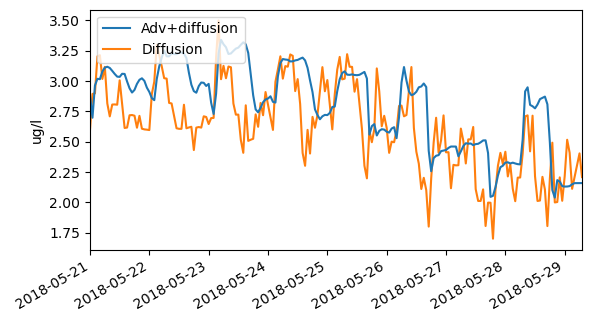

In [88]:
fig,ax=plt.subplots(figsize=[6,3.2])

ax.plot( franks_df.time, ad_result, label='Adv+diffusion')
ax.plot( franks_df.time, diff_result, label='Diffusion',zorder=-1)

ax.legend(loc='upper left')
fig.autofmt_xdate()
fig.subplots_adjust(left=0.15,right=0.97,top=0.97,bottom=0.22)

ax.axis(xmin=franks_df.time.min(),xmax=franks_df.time.max())
ax.set_ylabel(units)
fig.savefig(os.path.join(fig_dir,f'timeseries-compare-franks_tracts-{analyte}.png'))

Diffusion, but with Hydrodynamic-derived Diffusion Coefficients
==

Can throw in various scalar fields, get pair-wise covariance or correlation estimates.

How to relate correlation to diffusion coefficient?

I think this is **Kriging**.



Predicting from Antecedent Bed Stress
==

In [22]:
# choose one of the july dates. 2018-07-25
cruise_df_thin.groupby(cruise_df_thin.time.dt.date).size()

time
2018-05-15     974
2018-05-16     956
2018-05-17     821
2018-05-18      31
2018-07-24     812
2018-07-25    1320
2018-07-26    1049
2018-08-23     861
2018-08-24      14
2018-09-05     838
2018-09-13     621
2018-09-14     107
2018-10-04     314
2018-10-17     922
2018-10-18    1055
2018-10-19    1088
2018-10-20      54
dtype: int64

<IPython.core.display.Javascript object>


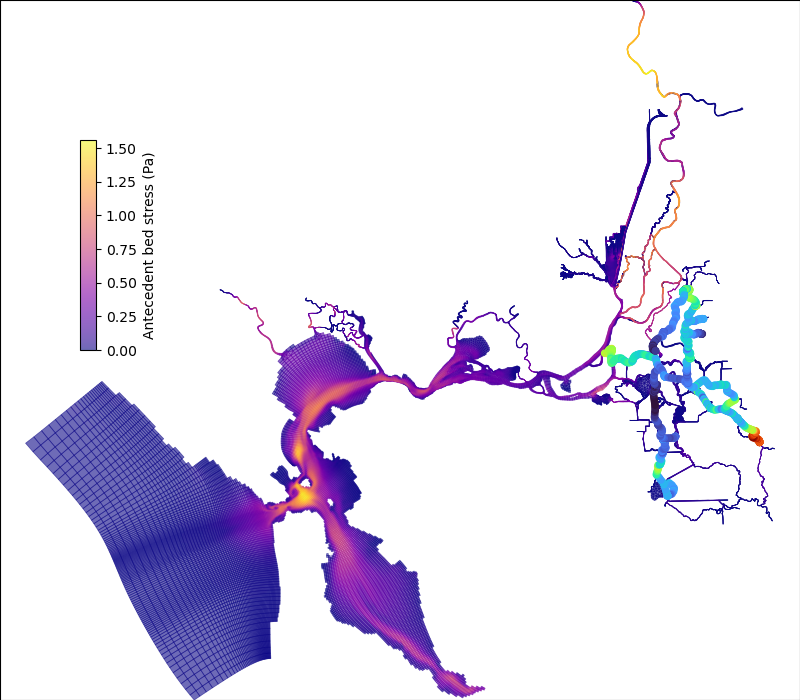

In [23]:
# First just check out the bed stress, 
# choose a snapshot from about the same time as a cruise
# Quick look is not promising.
# HERE: but do the extraction, plot a scatter.

snap=map_ds.sel(time=np.datetime64("2018-07-25 19:00"),method='nearest')
cruise_snap=cruise_df_thin[ cruise_df_thin.time.dt.date==np.datetime64("2018-07-25")]


fig,ax=plt.subplots(figsize=(8,7))
ax.set_adjustable('datalim')
ax.set_position([0,0,1,1])
cax=fig.add_axes([0.1,0.5,0.02,0.3])

tau=snap['mesh2d_tauDecay0'].values
ccoll=map_ds.grid.plot_cells(values=tau,cmap='plasma',lw=0.5,edgecolor='face',ax=ax,
                             alpha=0.6)

scat=ax.scatter(cruise_snap.x, cruise_snap.y, 20, cruise_snap['turb'], cmap='turbo')
plt.colorbar(ccoll,cax=cax,label='Antecedent bed stress (Pa)')

In [24]:
# Extract bed stress at time/location of each underway data point
# For starters keep it in one day so we're not getting a bunch of
# seasonal variation, too.

#cruise_snap=cruise_df_thin[ cruise_df_thin.date==np.datetime64("2018-07-25")]
#cruise_snap=cruise_df_thin[ cruise_df_thin.date==np.datetime64("2018-07-24")]
#cruise_snap=cruise_df_thin[ cruise_df_thin.date==np.datetime64("2018-07-26")]
cruise_snap=cruise_df_thin

map_times=map_ds.time.values

cruise_w_tau=cruise_snap.copy()
cruise_w_tau['tau']=np.nan
cruise_w_tau['tau0']=np.nan
cruise_w_tau['tau1']=np.nan
cruise_w_tau['pred_advd']=np.nan
cruise_w_tau['pred_diff']=np.nan
cruise_xy=cruise_w_tau[ ['x','y'] ].values

tidxs=np.searchsorted(map_times, cruise_snap.time.values)

ad_predictor=AdvDiffPredictor(map_ds=map_ds,scal='turb',alpha=1e-5)
diff_predictor=DiffusionPredictor(grid=map_ds.grid, mon_ds=turb_ds,mon_field='turbidity')

for tidx,grp in utils.enumerate_groups(tidxs):
    snap=map_ds.isel(time=tidx)
    cells=[map_ds.grid.select_cells_nearest(pnt)
           for pnt in cruise_xy[grp,:]]
    cruise_w_tau['tau'].values[grp]  = snap['mesh2d_taus'].values[cells]
    cruise_w_tau['tau0'].values[grp] = snap['mesh2d_tauDecay0'].values[cells]
    cruise_w_tau['tau1'].values[grp] = snap['mesh2d_tauDecay1'].values[cells]
    
    # Go ahead and populate with flavors of prediction, too.
    advd_map=ad_predictor.predict_map(map_times[tidx])
    diff_map=diff_predictor.predict_map(map_times[tidx])
    cruise_w_tau['pred_advd'].values[grp] = advd_map[cells]
    cruise_w_tau['pred_diff'].values[grp] = diff_map[cells]
    
assert np.all(cruise_w_tau['tau'].notnull())
assert np.all(cruise_w_tau['tau0'].notnull())
assert np.all(cruise_w_tau['tau1'].notnull())

Checking finite geometry
Checking finite geometry


<IPython.core.display.Javascript object>


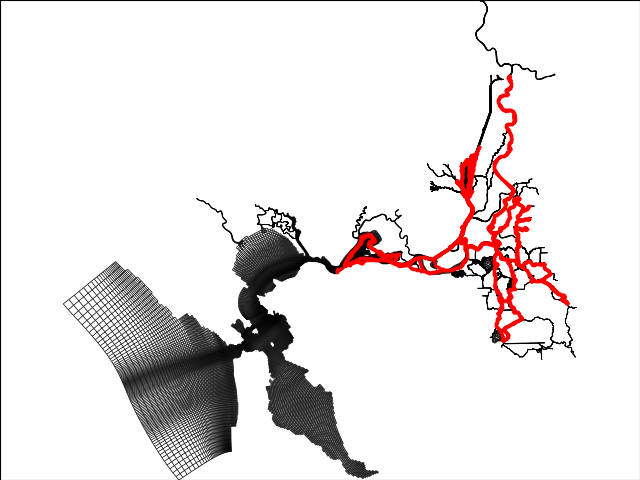

In [25]:
# Where was this cruise?
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
ax.set_position([0,0,1,1])

map_ds.grid.plot_edges(lw=0.5,color='k',ax=ax)
ax.plot(cruise_w_tau.x, cruise_w_tau.y, 'r.',ms=3, alpha=0.5)

<IPython.core.display.Javascript object>


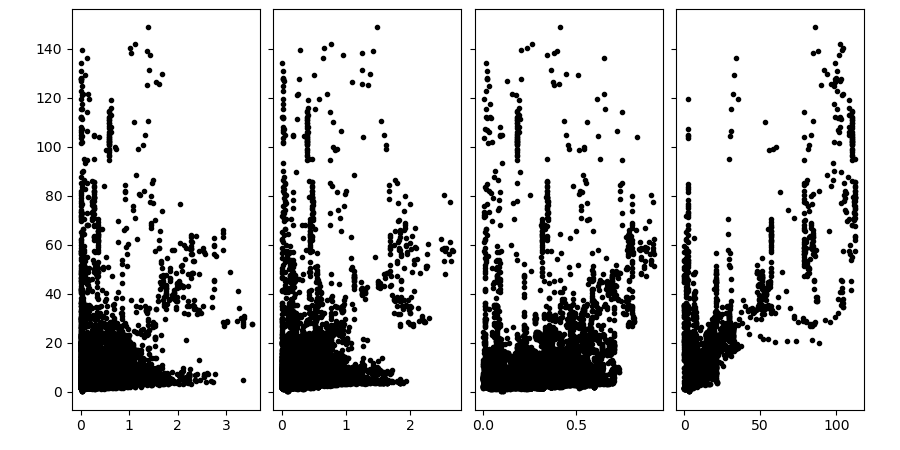

In [26]:
fig,axs=plt.subplots(1,4,sharex=False,sharey=True,figsize=(9,4.5))

for ax,scal in zip(axs,['tau','tau0','tau1','pred_diff']):
    ax.plot(cruise_w_tau[scal], cruise_w_tau['turb'], 'k.')

fig.subplots_adjust(left=0.08,right=0.96,top=0.98,bottom=0.09, wspace=0.07)


In [27]:
# Start trying some multiple linear regression
# Doing this for a single day of underway, 2018-07-25. Turns out
# the diffusion predictor on this day is pretty bad. Either it's a tricky
# day, or the skill of the diffusion predictor is coming largely from the
# cruise-to-cruise temporal variability, and not really from the interpolation. 

In [28]:
mod = smf.ols(formula='turb ~ tau', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     452.0
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.89e-98
Time:                        18:29:26   Log-Likelihood:                -47899.
No. Observations:               11793   AIC:                         9.580e+04
Df Residuals:                   11791   BIC:                         9.582e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3421      0.168     43.790      0.000       7.013       7.671
tau            6.0555      0.285     21.259      0.000       5.497       6.614
==============================================================================
Omnibus:                    11255.824   Durbin-Watson:                   0.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           442565.272
Skew:                           4.755   Prob(JB):                         0.00
Kurtosis:                      31.464   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
mod = smf.ols(formula='turb ~ tau0', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     686.6
Date:                Tue, 15 Aug 2023   Prob (F-statistic):          3.79e-147
Time:                        18:29:26   Log-Likelihood:                -47787.
No. Observations:               11793   AIC:                         9.558e+04
Df Residuals:                   11791   BIC:                         9.559e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4054      0.177     36.163      0.000       6.058       6.753
tau0           8.6165      0.329     26.203      0.000       7.972       9.261
==============================================================================
Omnibus:                    11269.499   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           456231.820
Skew:                           4.751   Prob(JB):                         0.00
Kurtosis:                      31.952   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
mod = smf.ols(formula='turb ~ tau1', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     367.5
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.12e-80
Time:                        18:29:26   Log-Likelihood:                -47940.
No. Observations:               11793   AIC:                         9.588e+04
Df Residuals:                   11791   BIC:                         9.590e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0592      0.226     26.791      0.000       5.616       6.502
tau1          12.4014      0.647     19.169      0.000      11.133      13.670
==============================================================================
Omnibus:                    11373.565   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           464074.000
Skew:                           4.822   Prob(JB):                         0.00
Kurtosis:                      32.179   Cond. No.                         5.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
mod = smf.ols(formula='turb ~ pred_diff', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                 2.401e+04
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:29:26   Log-Likelihood:                -41571.
No. Observations:               11793   AIC:                         8.315e+04
Df Residuals:                   11791   BIC:                         8.316e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4056      0.089     27.089      0.000       2.232       2.580
pred_diff      0.7693      0.005    154.966      0.000       0.760       0.779
==============================================================================
Omnibus:                    11420.525   Durbin-Watson:                   0.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           905162.589
Skew:                           4.554   Prob(JB):                         0.00
Kurtosis:                      44.942   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
mod = smf.ols(formula='turb ~ pred_advd', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                 2.019e+04
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:29:26   Log-Likelihood:                -42238.
No. Observations:               11793   AIC:                         8.448e+04
Df Residuals:                   11791   BIC:                         8.449e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0388      0.105      0.371      0.711      -0.166       0.244
pred_advd      1.2091      0.009    142.082      0.000       1.192       1.226
==============================================================================
Omnibus:                    11129.027   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           597987.979
Skew:                           4.520   Prob(JB):                         0.00
Kurtosis:                      36.693   Cond. No.                         16.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Kitchen sink:
mod = smf.ols(formula='turb ~ tau + tau1 + tau0 + pred_diff + pred_advd', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     5168.
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:29:26   Log-Likelihood:                -41276.
No. Observations:               11793   AIC:                         8.256e+04
Df Residuals:                   11787   BIC:                         8.261e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4381      0.136     17.892      0.000       2.171       2.705
tau           -1.4503      0.279     -5.205      0.000      -1.996      -0.904
tau1          -5.5054      0.615     -8.952      0.000      -6.711      -4.300
tau0           2.0392      0.419      4.863      0.000       1.217       2.861
pred_diff      0.5242      0.013     41.640      0.000       0.499       0.549
pred_advd      0.4578      0.021     22.328      0.000       0.418       0.498
==============================================================================
Omnibus:                    11711.313   Durbin-Watson:                   0.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           868842.643
Skew:                           4.788   Prob(JB):                         0.00
Kurtosis:                      43.945   Cond. No.                         200.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# Half-kitchen sink:
# Was interesting on a single day, but not so interesting across multiple days
# 2018-07-25: R2=0.202
# turb = 16.88 tau0 - 11.23 tau1 - 4.59 tau + 6.25
# But does it hold for other days / regions?
# 2018-07-24: R2=0.248
# turb = -2.96 tau0 + 13.44 tau1 + 1.71 tau + 3.11 
# 2018-07-26: Rs=0.182
# turb = -8.46 tau0 -3.2 tau1 -9.62 tau + 32
# Basically useless. The various tau values provide some spatial patterns that 
# loosely tag water, and OLS overfits.
mod = smf.ols(formula='turb ~ tau0 + tau1 + tau', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     230.2
Date:                Tue, 15 Aug 2023   Prob (F-statistic):          3.63e-145
Time:                        18:29:53   Log-Likelihood:                -47785.
No. Observations:               11793   AIC:                         9.558e+04
Df Residuals:                   11789   BIC:                         9.561e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6709      0.227     29.351      0.000       6.225       7.116
tau0           9.2590      0.723     12.805      0.000       7.842      10.676
tau1          -1.9900      1.039     -1.915      0.056      -4.027       0.047
tau            0.1743      0.480      0.363      0.716      -0.766       1.114
==============================================================================
Omnibus:                    11242.458   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           451529.947
Skew:                           4.735   Prob(JB):                         0.00
Kurtosis:                      31.796   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Bed stress was weakly predictive turbidity when trained on the full 
set of underway data. Three different aggregations of bed stress were
tested: instantaneous, one hour exponential smoothing, and 24 h
exponential smoothing. Of those model outputs, one hour smoothing
was the most predictive but still had an R$^2$ of only 0.05. This
analysis quantized all times to integer hours, which also decreased
the skill of the diffusion and adv+diffusion approaches. These
attained R$^2$ scores of 0.671 and 0.631, respectively.



In [35]:
# Rather than comparing over underway data, compare with monitoring data since 
# that is what we'd be using in a real application.

# 15 minute data, 38 sites, 2018-04-01 to 2018-11-01
mon_ds=turb_ds 
mon_and_map_fn = "turb-mon_and_map.nc"

# Since we have decaying tracers spinup doesn't need to be all that long.
spinup_period = np.timedelta64(10,'D')

time_sel=( (mon_ds.time.values>= map_ds.time.values[0] + spinup_period)
          &(mon_ds.time.dt.minute.values==0))

mon_ds=mon_ds.isel(time=time_sel)

# Pull these from the model output 
map_fields=[
 'mesh2d_turb_wt',
 'mesh2d_turb_wtobs',
 'mesh2d_taus',
 'mesh2d_tauDecay0',
 'mesh2d_tauDecay1',
]

data={f:np.full((mon_ds.dims['time'], mon_ds.dims['site']),np.nan)
      for f in map_fields}

site_xy=np.c_[mon_ds.x.values, mon_ds.y.values]
site_cell=[map_ds.grid.select_cells_nearest(xy) for xy in site_xy]

for mon_tidx in utils.progress(range(mon_ds.dims['time'])):
    mon_time = mon_ds.time.values[mon_tidx]
    snap=map_ds.isel(time=np.searchsorted(map_ds.time.values, mon_time))
    
    for f in map_fields:
        data[f][mon_tidx,:] = snap[f].isel(mesh2d_nFaces=site_cell)
        

INFO:utils:12/4896
INFO:utils:25/4896
INFO:utils:38/4896
INFO:utils:51/4896
INFO:utils:63/4896
INFO:utils:76/4896
INFO:utils:88/4896
INFO:utils:101/4896
INFO:utils:114/4896
INFO:utils:127/4896
INFO:utils:140/4896
INFO:utils:153/4896
INFO:utils:166/4896
INFO:utils:180/4896
INFO:utils:193/4896
INFO:utils:206/4896
INFO:utils:219/4896
INFO:utils:232/4896
INFO:utils:245/4896
INFO:utils:257/4896
INFO:utils:271/4896
INFO:utils:284/4896
INFO:utils:297/4896
INFO:utils:311/4896
INFO:utils:325/4896
INFO:utils:338/4896
INFO:utils:352/4896
INFO:utils:365/4896
INFO:utils:379/4896
INFO:utils:393/4896
INFO:utils:406/4896
INFO:utils:420/4896
INFO:utils:434/4896
INFO:utils:448/4896
INFO:utils:462/4896
INFO:utils:475/4896
INFO:utils:489/4896
INFO:utils:503/4896
INFO:utils:517/4896
INFO:utils:530/4896
INFO:utils:544/4896
INFO:utils:557/4896
INFO:utils:570/4896
INFO:utils:583/4896
INFO:utils:596/4896
INFO:utils:609/4896
INFO:utils:622/4896
INFO:utils:635/4896
INFO:utils:648/4896
INFO:utils:662/4896
INFO:ut

INFO:utils:4829/4896
INFO:utils:4841/4896
INFO:utils:4853/4896
INFO:utils:4866/4896
INFO:utils:4878/4896
INFO:utils:4890/4896


In [36]:
for f in map_fields:
    mon_ds[f]=('time','site'), data[f]

In [37]:
mon_ds.to_netcdf(mon_and_map_fn)